In [1]:
from pathlib import Path 
import sys 
sys.path.append(str(Path.cwd().parent))

In [2]:
from utils import predictors, data_loading as dl
from pathlib import Path 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/home/glegeza/Programming/semestr1/time-series-forecasting/venv10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
MAX_PLOT_HORIZON = 1000
MAX_PLOT_TRAIN = 100

EVALUATION_RESULTS = {}

In [4]:
def plot_predictions(y_train, y_test, y_hat_test):
    xrange_train = np.arange(y_train.shape[0])
    xrange_test = np.arange(y_train.shape[0], y_train.shape[0] + y_test.shape[0])
    sns.lineplot(y=y_train, x=xrange_train, label="train")
    sns.lineplot(y=y_test, x=xrange_test, label="test")
    if y_hat_test is not None:
        sns.lineplot(y=y_hat_test, x=xrange_test, label="prediction")
    # plot vertical dotted line
    plt.axvline(x=y_train.shape[0], linestyle="--", color="black")
    plt.legend()

In [5]:
def calculate_rmse(y_test, y_hat_test):
    se = (y_hat_test - y_test) ** 2
    predicted_days = np.arange(1, se.shape[0]+1)
    rmse = np.sqrt(np.cumsum(se) / predicted_days)

    for h in [10, 50, 100, 200, 300, 1000, y_test.shape[0]]:
        if h > y_test.shape[0]:
            continue
        print(f"{h} steps horizon - rmse = {round(rmse[h-1], 4)}")

    sns.lineplot(y=rmse, x=predicted_days, label="rmse")
    return rmse

# Datasets

In [6]:
sunspots = dl.DataLoader(dl.DATASET.SUNSPOTS, use_test=True)
electricity = dl.DataLoader(dl.DATASET.ELECTRICITY, use_test=True)
mackey_glass = dl.DataLoader(dl.DATASET.MACKEY_GLASS, use_test=True)
temperature = dl.DataLoader(dl.DATASET.TEMPERATURE, use_test=True)

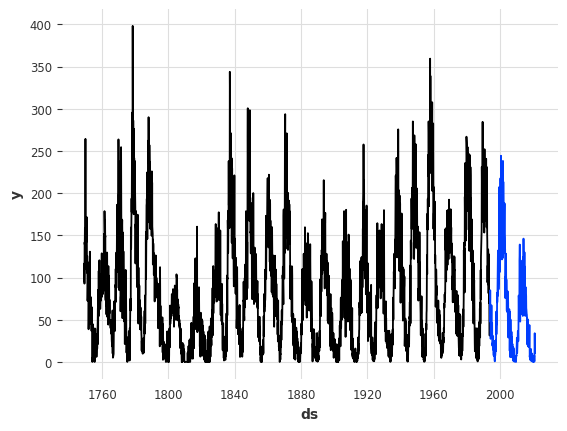

In [7]:
sns.lineplot(data=sunspots.train_df, x="ds", y="y")
sns.lineplot(data=sunspots.val_df, x="ds", y="y")
plt.show()

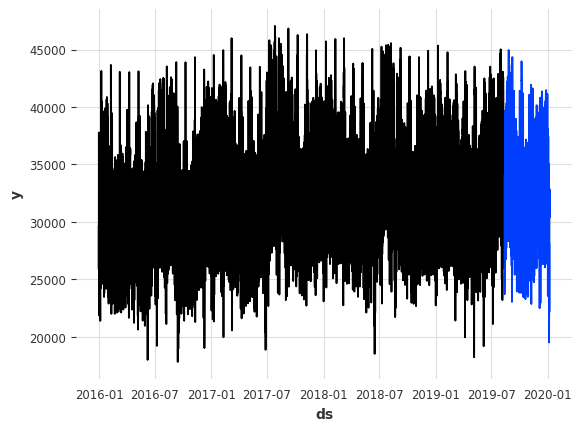

In [8]:
sns.lineplot(data=electricity.train_df, x="ds", y="y")
sns.lineplot(data=electricity.val_df, x="ds", y="y")
plt.show()

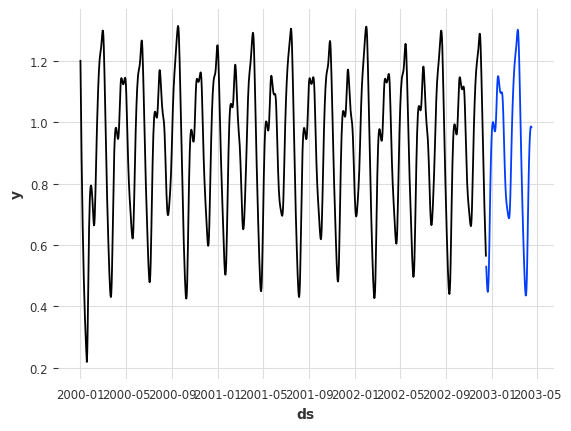

In [9]:
sns.lineplot(data=mackey_glass.train_df, x="ds", y="y")
sns.lineplot(data=mackey_glass.val_df, x="ds", y="y")
plt.show()

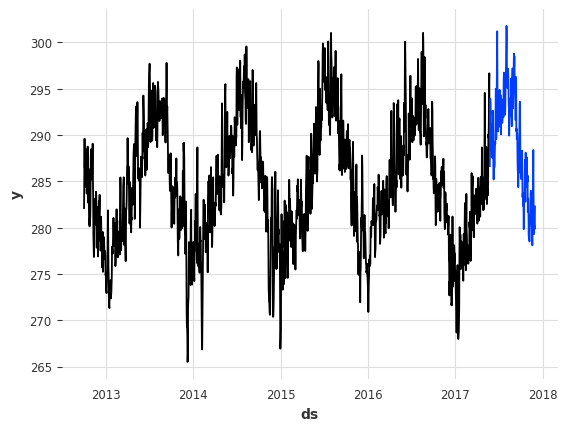

In [10]:
sns.lineplot(data=temperature.train_df, x="ds", y="y")
sns.lineplot(data=temperature.val_df, x="ds", y="y")
plt.show()

# Forecasting with Prophet

## Train model

In [11]:
model_name = "prophet"
EVALUATION_RESULTS[model_name] = {}

models = {}
datasets = [sunspots, electricity, mackey_glass, temperature]
prophet_params = {
    dl.DATASET.SUNSPOTS: {
        "seasonality_mode": "multiplicative",
        "daily_seasonality": False,
        "weekly_seasonality": False,
        "custom_seasonality": int(11 * 365),
        "changepoint_prior_scale": 0.1,
        "seasonality_prior_scale": 1.0,
    },
    dl.DATASET.ELECTRICITY: {
        "changepoint_prior_scale": 0.01,
        "seasonality_prior_scale": 0.01,
        "seasonality_mode": "additive",
    },
    dl.DATASET.MACKEY_GLASS: {
        "changepoint_prior_scale": 0.1,
        "seasonality_prior_scale": 1.0,
        "seasonality_mode": "multiplicative",
        "custom_seasonality": 100,
    },
    dl.DATASET.TEMPERATURE: {
        "changepoint_prior_scale": 0.1,
        "seasonality_prior_scale": 1.0,
        "seasonality_mode": "additive",
    },
}

for dataset in datasets:
    print(dataset.name)
    df_train = dataset.y_train_df
    print(df_train.shape)
    params = prophet_params[dataset.name]
    model = predictors.ProphetPredictor(**params)
    model.fit(df_train)
    models[dataset.name] = model

    EVALUATION_RESULTS[model_name][dataset.name] = {}
    EVALUATION_RESULTS[model_name][dataset.name]["model"] = model

DATASET.SUNSPOTS
(2938, 2)


20:36:22 - cmdstanpy - INFO - Chain [1] start processing
20:36:23 - cmdstanpy - INFO - Chain [1] done processing


DATASET.ELECTRICITY
(31707, 2)


20:36:26 - cmdstanpy - INFO - Chain [1] start processing
20:36:35 - cmdstanpy - INFO - Chain [1] done processing
20:36:35 - cmdstanpy - INFO - Chain [1] start processing


DATASET.MACKEY_GLASS
(1080, 2)


20:36:36 - cmdstanpy - INFO - Chain [1] done processing
20:36:36 - cmdstanpy - INFO - Chain [1] start processing


DATASET.TEMPERATURE
(1697, 2)


20:36:37 - cmdstanpy - INFO - Chain [1] done processing


## Evaluate model

DATASET.SUNSPOTS


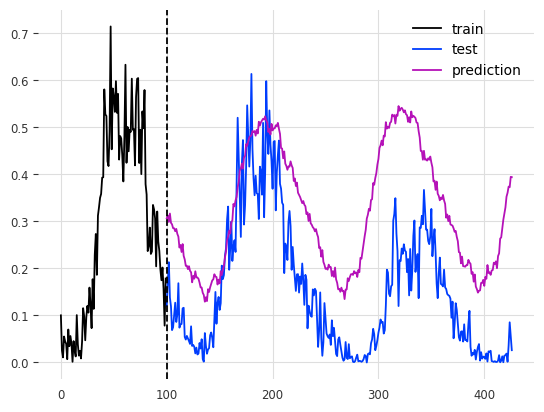

10 steps horizon - rmse = 0.178
50 steps horizon - rmse = 0.1425
100 steps horizon - rmse = 0.1191
200 steps horizon - rmse = 0.1585
300 steps horizon - rmse = 0.1894
327 steps horizon - rmse = 0.1955


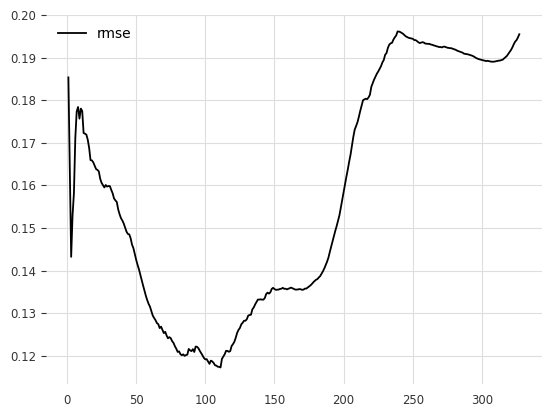


******************************

DATASET.ELECTRICITY


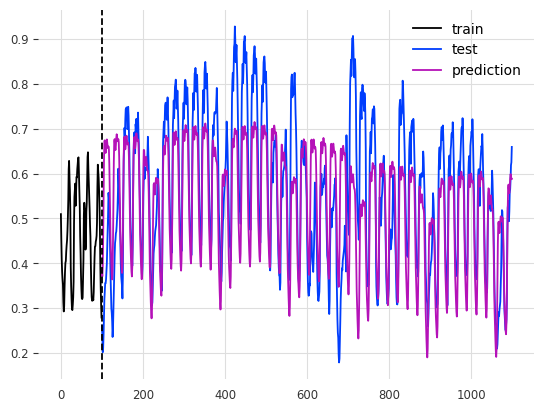

10 steps horizon - rmse = 0.2738
50 steps horizon - rmse = 0.1923
100 steps horizon - rmse = 0.1397
200 steps horizon - rmse = 0.11
300 steps horizon - rmse = 0.1034
1000 steps horizon - rmse = 0.1144
3524 steps horizon - rmse = 0.1048


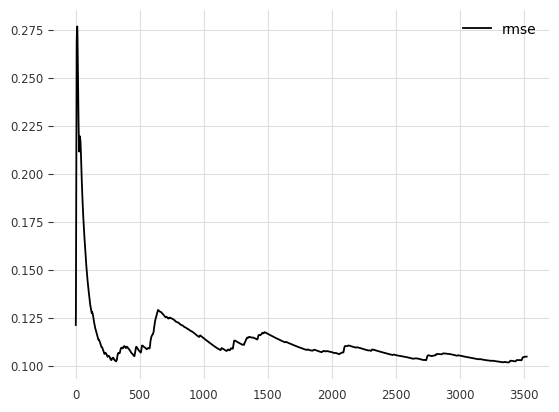


******************************

DATASET.MACKEY_GLASS


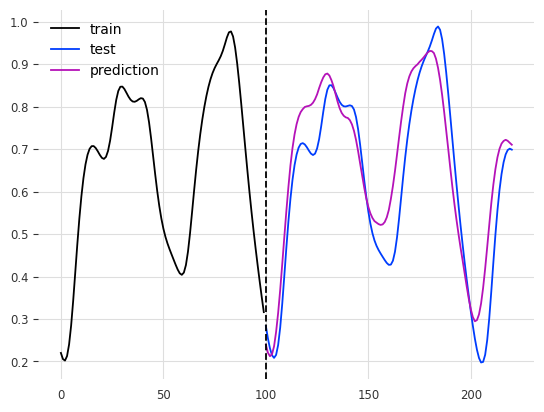

10 steps horizon - rmse = 0.0614
50 steps horizon - rmse = 0.0685
100 steps horizon - rmse = 0.0863
121 steps horizon - rmse = 0.0947


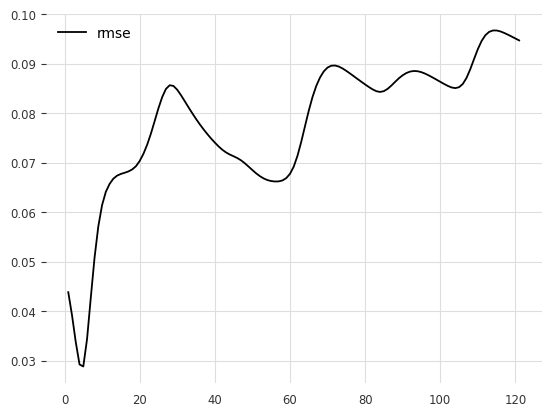


******************************

DATASET.TEMPERATURE


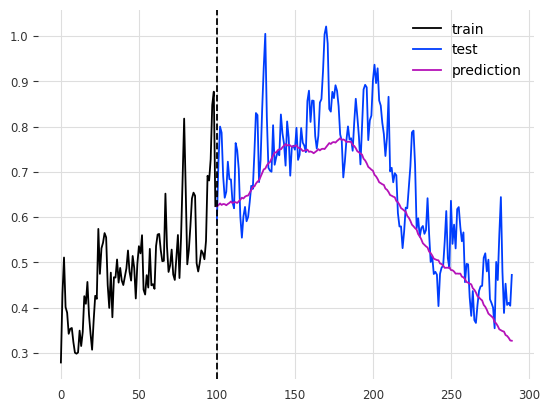

10 steps horizon - rmse = 0.0911
50 steps horizon - rmse = 0.0875
100 steps horizon - rmse = 0.0949
190 steps horizon - rmse = 0.0992


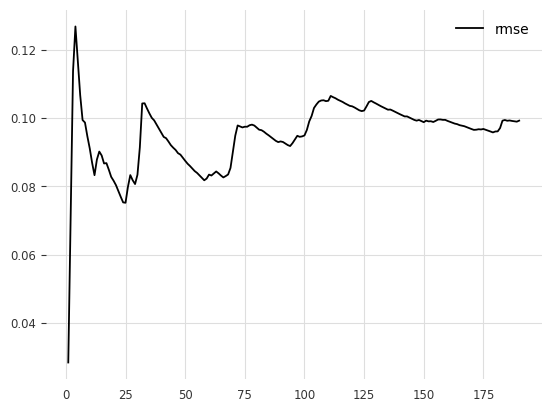


******************************



In [12]:
forecasts = {}
for dataset in datasets:
    y_val = dataset.y_val
    model = models[dataset.name]
    y_pred = model.forecast(dataset.df_val[["ds"]])

    print(dataset.name)
    
    plot_predictions(dataset.y_train[-MAX_PLOT_TRAIN: ].flatten(), y_val[:MAX_PLOT_HORIZON].flatten(), y_pred[:MAX_PLOT_HORIZON].flatten())
    plt.show()

    rmse = calculate_rmse(y_val.flatten(), y_pred.flatten())
    plt.show()
    print()
    print("*" * 30)
    print()

    EVALUATION_RESULTS[model_name][dataset.name]["prediction"] = y_pred
    EVALUATION_RESULTS[model_name][dataset.name]["rmse"] = rmse

# Forecasting with SARIMA

## Train model

In [13]:
model_name = "sarima"
EVALUATION_RESULTS[model_name] = {}

models = {}
datasets = [sunspots, electricity, mackey_glass, temperature]
sarima_params = {
    dl.DATASET.SUNSPOTS: {
        "order": (5, 0, 5),
        "seasonal_order": (2, 0, 2, 130),
    },
    dl.DATASET.ELECTRICITY: {
        "order": (3, 0, 5),
        "seasonal_order": (1, 0, 2, 24),
    },
    dl.DATASET.MACKEY_GLASS: {
        "order": (5, 0, 5),
        "seasonal_order": (2, 0, 2, 100),
    },
    dl.DATASET.TEMPERATURE: {
        "order": (5, 0, 5),
        "seasonal_order": (2, 0, 2, 365),
    },
}

for dataset in datasets:
    print(dataset.name)
    df_train = dataset.y_train_df
    X_train = df_train.y.values
    print(X_train.shape)
    params = sarima_params[dataset.name]
    model = predictors.SARIMAPredictor(**params)
    model.fit(X_train)
    models[dataset.name] = model

    EVALUATION_RESULTS[model_name][dataset.name] = {}
    EVALUATION_RESULTS[model_name][dataset.name]["model"] = model

DATASET.SUNSPOTS
(2938,)


/home/glegeza/Programming/semestr1/time-series-forecasting/venv10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


DATASET.ELECTRICITY
(31707,)


/home/glegeza/Programming/semestr1/time-series-forecasting/venv10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


DATASET.MACKEY_GLASS
(1080,)
DATASET.TEMPERATURE
(1697,)


/home/glegeza/Programming/semestr1/time-series-forecasting/venv10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## Evaluate model

DATASET.SUNSPOTS


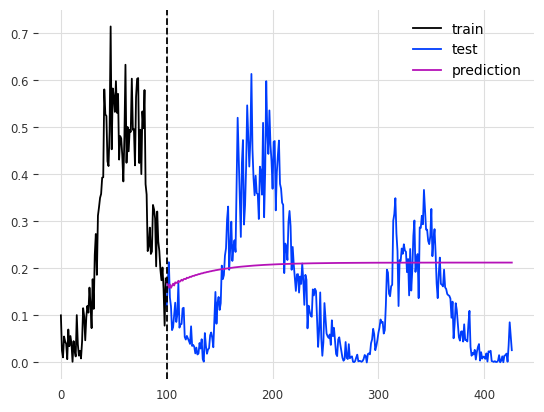

10 steps horizon - rmse = 0.0619
50 steps horizon - rmse = 0.1218
100 steps horizon - rmse = 0.1627
200 steps horizon - rmse = 0.1593
300 steps horizon - rmse = 0.1448
327 steps horizon - rmse = 0.1499


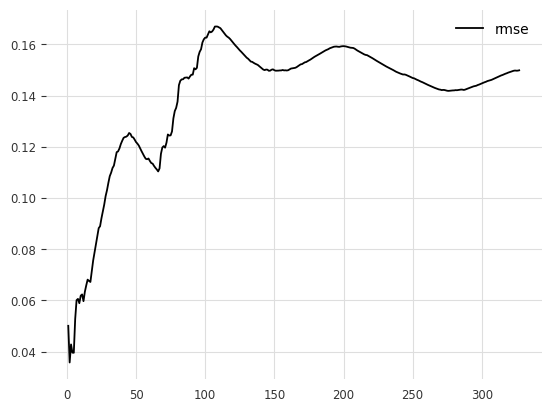


******************************

DATASET.ELECTRICITY


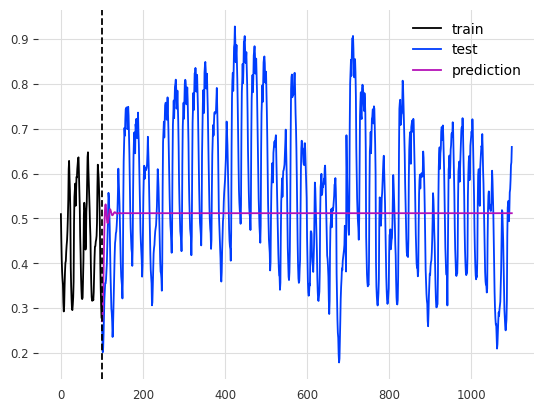

10 steps horizon - rmse = 0.1343
50 steps horizon - rmse = 0.1277
100 steps horizon - rmse = 0.1415
200 steps horizon - rmse = 0.147
300 steps horizon - rmse = 0.1652
1000 steps horizon - rmse = 0.1679
3524 steps horizon - rmse = 0.1586


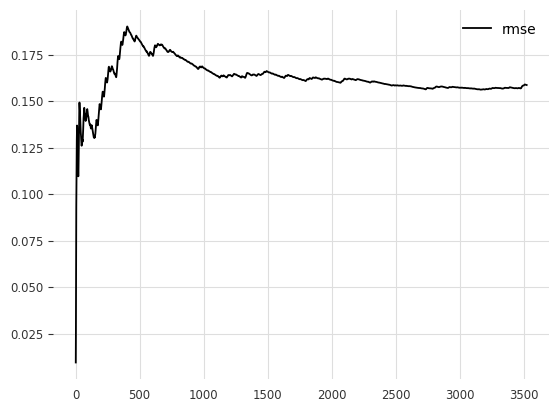


******************************

DATASET.MACKEY_GLASS


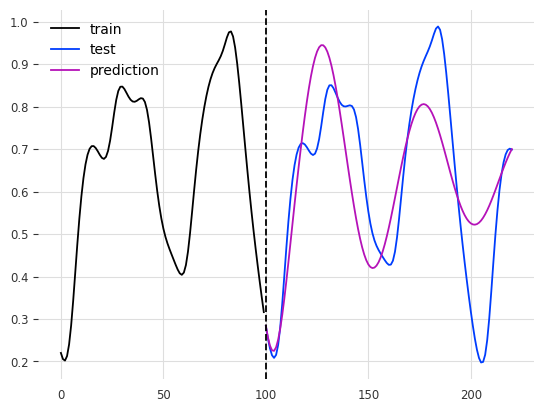

10 steps horizon - rmse = 0.0212
50 steps horizon - rmse = 0.129
100 steps horizon - rmse = 0.125
121 steps horizon - rmse = 0.144


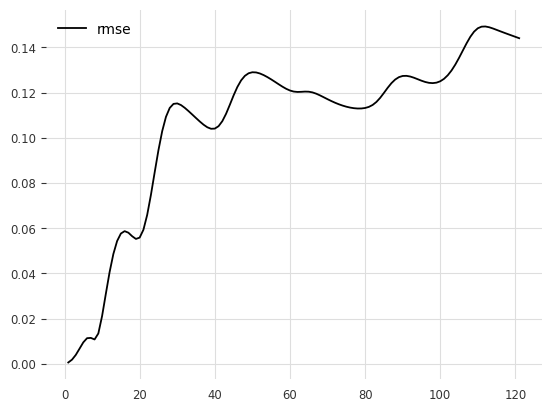


******************************

DATASET.TEMPERATURE


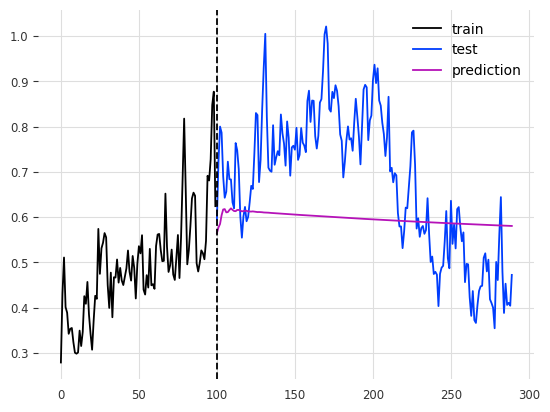

10 steps horizon - rmse = 0.1144
50 steps horizon - rmse = 0.1439
100 steps horizon - rmse = 0.1924
190 steps horizon - rmse = 0.1694


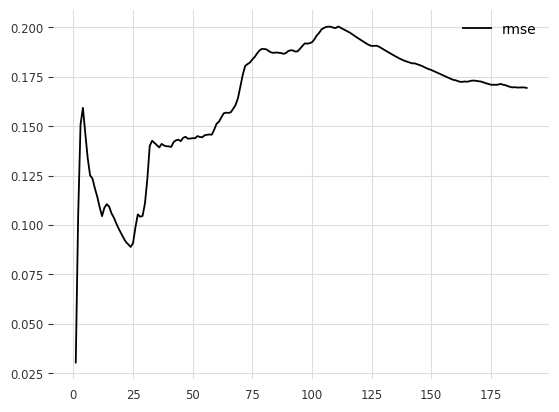


******************************



In [14]:
forecasts = {}
for dataset in datasets:
    y_val = dataset.y_val
    model = models[dataset.name]
    y_pred = model.forecast(y_val.shape[0])
    print(dataset.name)
    
    plot_predictions(dataset.y_train[-MAX_PLOT_TRAIN: ].flatten(), y_val[:MAX_PLOT_HORIZON].flatten(), y_pred[:MAX_PLOT_HORIZON].flatten())
    plt.show()

    rmse = calculate_rmse(y_val.flatten(), y_pred.flatten())
    plt.show()
    print()
    print("*" * 30)
    print()

    EVALUATION_RESULTS[model_name][dataset.name]["prediction"] = y_pred
    EVALUATION_RESULTS[model_name][dataset.name]["rmse"] = rmse

# Forecasting with TFT

## Train model

In [15]:
MODEL_DIR = Path().cwd().parent / "models/tft"

model_name = "tft"
EVALUATION_RESULTS[model_name] = {}

model_electricity = predictors.TFTPredictor().load(str(MODEL_DIR / "electricity08:06:31"))
model_sunspots = predictors.TFTPredictor().load(str(MODEL_DIR / "sunspots01:52:41"))
model_mackey_glass = predictors.TFTPredictor().load(str(MODEL_DIR / "mackey_glass08:16:47"))
model_temperature = predictors.TFTPredictor().load(str(MODEL_DIR / "temperature08:33:50"))

models = {
    "electricity": model_electricity,
    "sunspots": model_sunspots,
    "mackey_glass": model_mackey_glass,
    "temperature": model_temperature,
}

for ds, model in models.items():
    EVALUATION_RESULTS[model_name][ds] = {}
    EVALUATION_RESULTS[model_name][ds]["model"] = model

## Evaluate model

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:06<00:00,  6.83s/it]
DATASET.SUNSPOTS


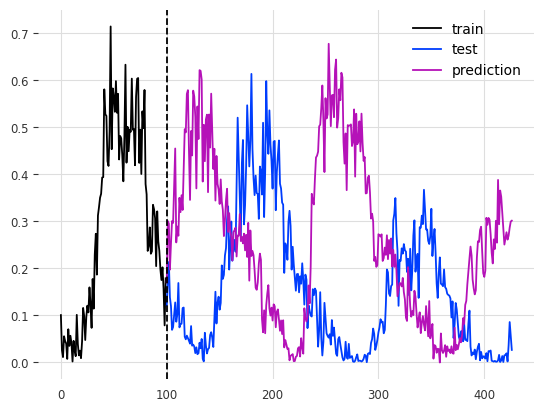

10 steps horizon - rmse = 0.1896
50 steps horizon - rmse = 0.3803
100 steps horizon - rmse = 0.3101
200 steps horizon - rmse = 0.3415
300 steps horizon - rmse = 0.2915
327 steps horizon - rmse = 0.2897


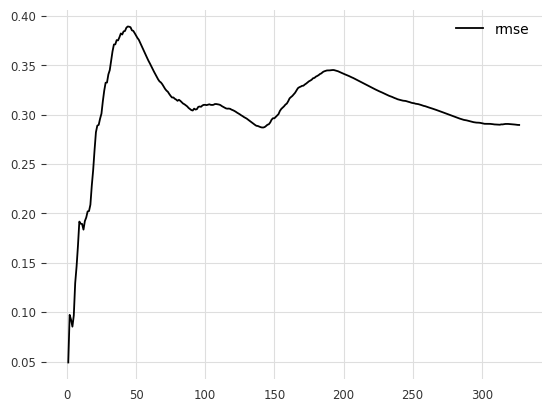

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



******************************

Predicting DataLoader 0: 100%|██████████| 1/1 [00:20<00:00, 20.39s/it]
DATASET.ELECTRICITY


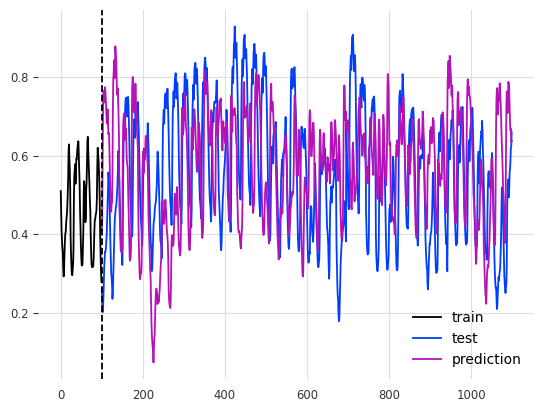

10 steps horizon - rmse = 0.4077
50 steps horizon - rmse = 0.2969
100 steps horizon - rmse = 0.2411
200 steps horizon - rmse = 0.2375
300 steps horizon - rmse = 0.2177
1000 steps horizon - rmse = 0.1943
1000 steps horizon - rmse = 0.1943


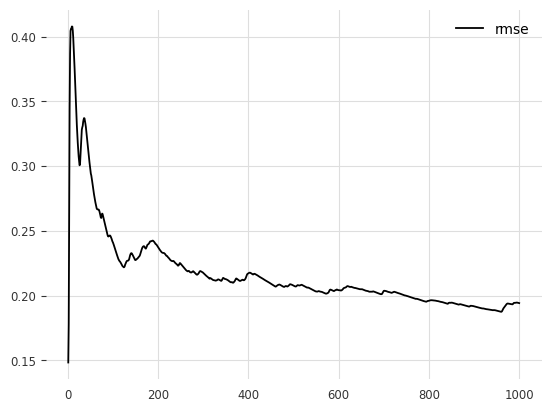

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



******************************

Predicting DataLoader 0: 100%|██████████| 1/1 [00:02<00:00,  2.54s/it]
DATASET.MACKEY_GLASS


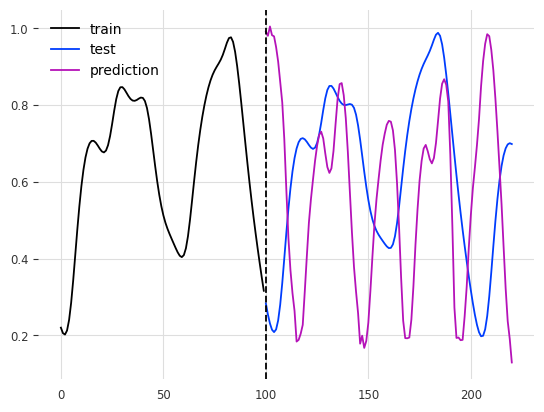

10 steps horizon - rmse = 0.6683
50 steps horizon - rmse = 0.4
100 steps horizon - rmse = 0.3497
121 steps horizon - rmse = 0.377


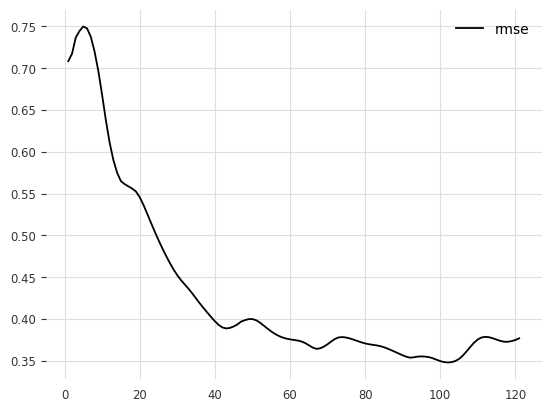

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



******************************

Predicting DataLoader 0: 100%|██████████| 1/1 [00:04<00:00,  4.17s/it]
DATASET.TEMPERATURE


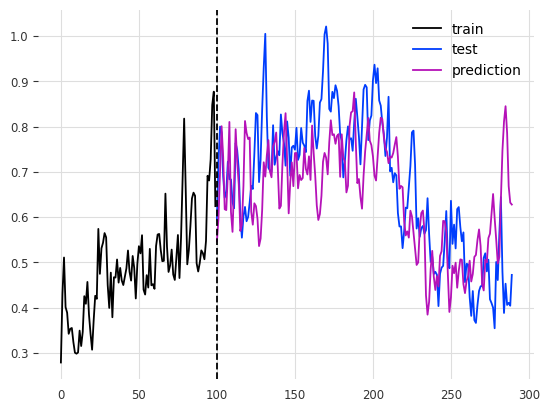

10 steps horizon - rmse = 0.0734
50 steps horizon - rmse = 0.1175
100 steps horizon - rmse = 0.1227
190 steps horizon - rmse = 0.1298


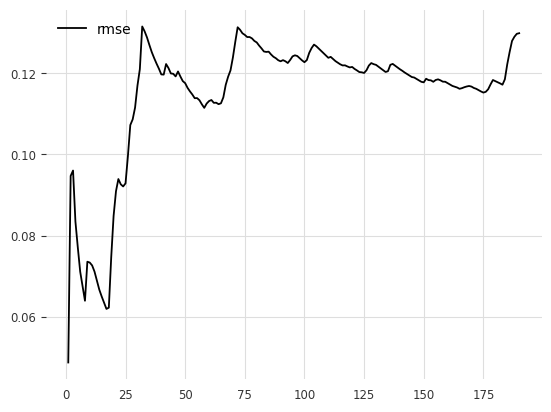


******************************



In [16]:

datasets = [sunspots, electricity, mackey_glass, temperature]
for dataset in datasets:
    y_val = dataset.y_val.flatten()
    model = models[dataset.name]
    horizon = min(10 * model.input_chunk_length, y_val.shape[0])
    y_pred = model.forecast(horizon)

    print(dataset.name)

    plot_predictions(dataset.y_train[-MAX_PLOT_TRAIN: ].flatten(), y_val[:MAX_PLOT_HORIZON], y_pred[:MAX_PLOT_HORIZON].flatten())
    # plot_predictions(dataset.y_train[-model.input_chunk_length: ].flatten(), y_val[:horizon], y_pred.flatten())
    plt.show()

    rmse = calculate_rmse(y_val[:horizon], y_pred.flatten())
    plt.show()
    print()
    print("*" * 30)
    print()

    EVALUATION_RESULTS[model_name][dataset.name]["prediction"] = y_pred
    EVALUATION_RESULTS[model_name][dataset.name]["rmse"] = rmse

# Forecasting with XGBoost

## Train model

In [17]:
model_name = "xgboost"
EVALUATION_RESULTS[model_name] = {}

models = {}
datasets = [sunspots, electricity, mackey_glass, temperature]
xgboost_params = {
    dl.DATASET.SUNSPOTS: {
        "n_estimators": 300,
        "max_depth": 10,
        "objective": "reg:squarederror",
        "booster": "gbtree",
        "include_hours": False,
        "lags": {
            "50 years lag": "18262 days",
            "40 years lag": "14610 days",
            "30 years lag": "10958 days"
        }
    },
    dl.DATASET.ELECTRICITY: {
        "n_estimators": 1000,
        "max_depth": 5,
        "objective": "reg:squarederror",
        "booster": "gbtree",
        "include_hours": True,
        "lags": {
            "8 months lag": "242 days",
            "6 months lag": "182 days",
            "4 months lag": "91 days"
        }
    },
    dl.DATASET.MACKEY_GLASS: {
        "n_estimators": 100,
        "max_depth": 10,
        "objective": "reg:squarederror",
        "booster": "gbtree",
        "include_hours": False,
        "lags": {
            "300 days lag": "300 days",
            "2 months lag": "61 days",
            "3 months lag": "91 days"
        }
    },
    dl.DATASET.TEMPERATURE: {
       "n_estimators": 1000,
        "max_depth": 5,
        "objective": "reg:squarederror",
        "booster": "gbtree",
        "include_hours": False,
        "lags": {
            "4 months lag": "91 days",
            "1 month lag": "30 days",
            "15 days lag": "15 days"
        } 
    }
}

for dataset in datasets:
    print(dataset.name)
    df_train = dataset.y_train_df
    print(df_train.shape)
    params = xgboost_params[dataset.name]
    model = predictors.XGBoostPredictor(**params)
    model.fit(df_train)
    models[dataset.name] = model

    EVALUATION_RESULTS[model_name][dataset.name] = {}
    EVALUATION_RESULTS[model_name][dataset.name]["model"] = model

DATASET.SUNSPOTS
(2938, 2)


/home/glegeza/Programming/semestr1/time-series-forecasting/utils/predictors.py:286: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  X_extended["weekofyear"] = pd.Int64Index(X.index.isocalendar().week)


DATASET.ELECTRICITY
(31707, 2)


/home/glegeza/Programming/semestr1/time-series-forecasting/utils/predictors.py:286: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  X_extended["weekofyear"] = pd.Int64Index(X.index.isocalendar().week)


DATASET.MACKEY_GLASS
(1080, 2)
DATASET.TEMPERATURE
(1697, 2)


/home/glegeza/Programming/semestr1/time-series-forecasting/utils/predictors.py:286: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  X_extended["weekofyear"] = pd.Int64Index(X.index.isocalendar().week)
/home/glegeza/Programming/semestr1/time-series-forecasting/utils/predictors.py:286: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  X_extended["weekofyear"] = pd.Int64Index(X.index.isocalendar().week)


## Evaluate model

/home/glegeza/Programming/semestr1/time-series-forecasting/utils/predictors.py:286: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  X_extended["weekofyear"] = pd.Int64Index(X.index.isocalendar().week)


DATASET.SUNSPOTS


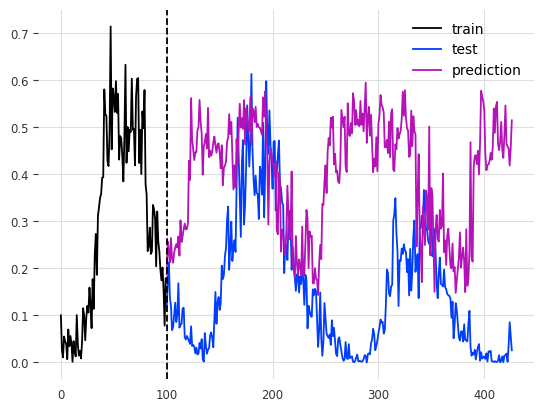

10 steps horizon - rmse = 0.1182
50 steps horizon - rmse = 0.3369
100 steps horizon - rmse = 0.2654
200 steps horizon - rmse = 0.302
300 steps horizon - rmse = 0.2898
327 steps horizon - rmse = 0.3072


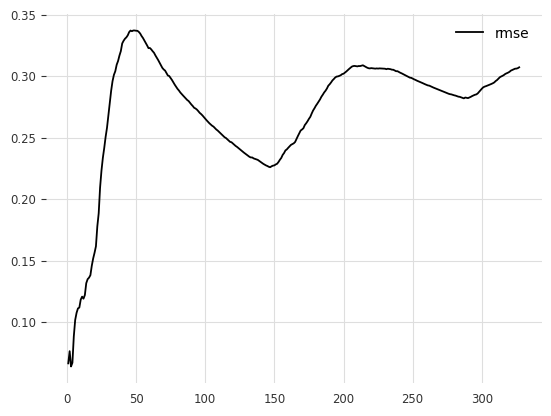


******************************



/home/glegeza/Programming/semestr1/time-series-forecasting/utils/predictors.py:286: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  X_extended["weekofyear"] = pd.Int64Index(X.index.isocalendar().week)


DATASET.ELECTRICITY


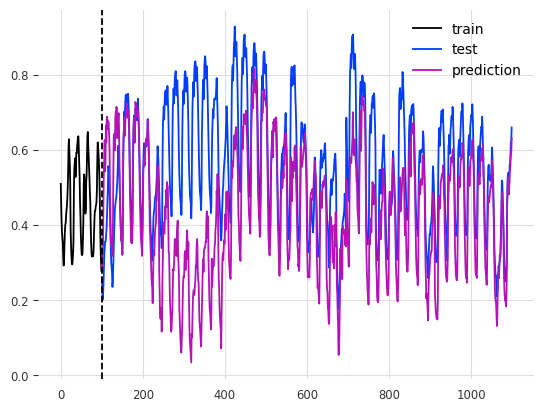

10 steps horizon - rmse = 0.1952
50 steps horizon - rmse = 0.1678
100 steps horizon - rmse = 0.1219
200 steps horizon - rmse = 0.2137
300 steps horizon - rmse = 0.2874
1000 steps horizon - rmse = 0.1888
3524 steps horizon - rmse = 0.156


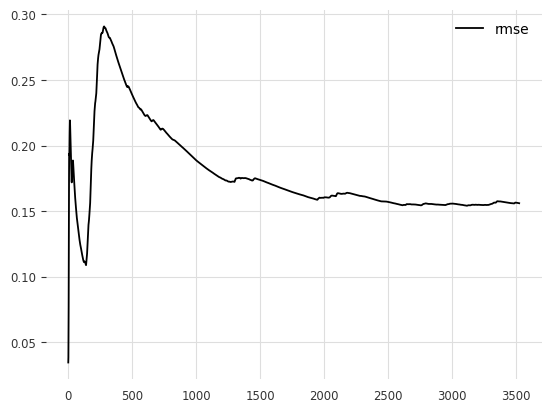


******************************

DATASET.MACKEY_GLASS


/home/glegeza/Programming/semestr1/time-series-forecasting/utils/predictors.py:286: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  X_extended["weekofyear"] = pd.Int64Index(X.index.isocalendar().week)


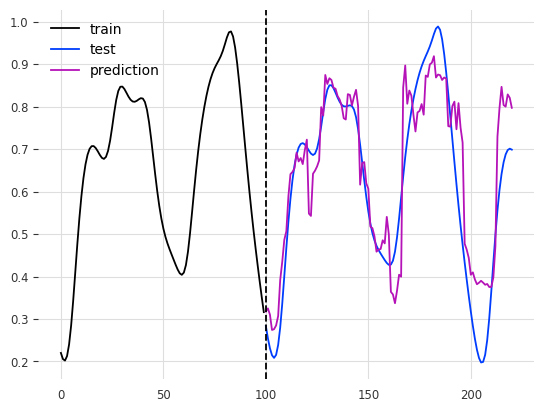

10 steps horizon - rmse = 0.0771
50 steps horizon - rmse = 0.0554
100 steps horizon - rmse = 0.0848
121 steps horizon - rmse = 0.0963


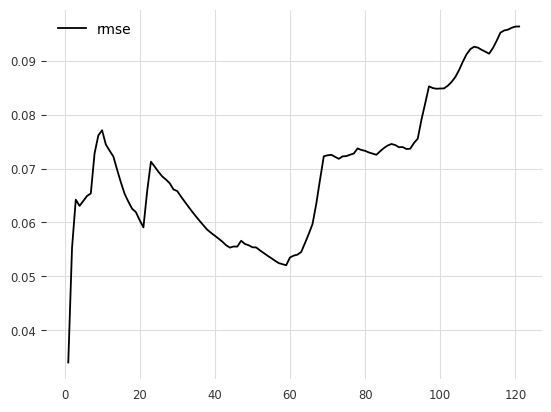


******************************

DATASET.TEMPERATURE


/home/glegeza/Programming/semestr1/time-series-forecasting/utils/predictors.py:286: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  X_extended["weekofyear"] = pd.Int64Index(X.index.isocalendar().week)


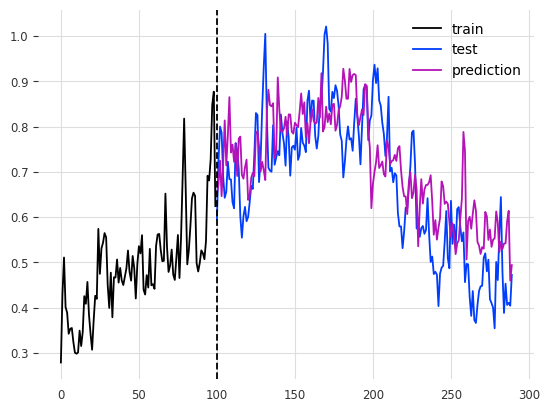

10 steps horizon - rmse = 0.102
50 steps horizon - rmse = 0.1054
100 steps horizon - rmse = 0.1013
190 steps horizon - rmse = 0.1126


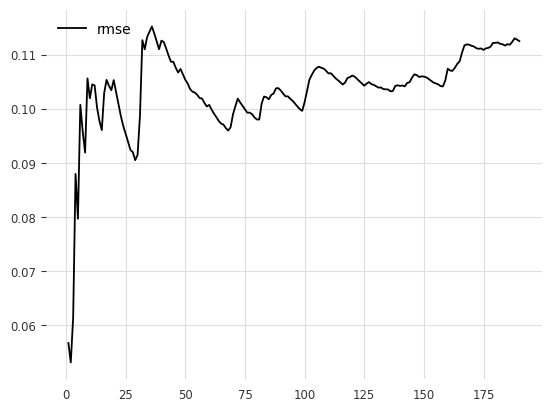


******************************



In [18]:
forecasts = {}
for i, dataset in enumerate(datasets):
    y_val = dataset.y_val
    df_val = pd.DataFrame({"ds": dataset.y_val_df.ds})
    model = models[dataset.name]
    y_pred = model.forecast(df_val)

    print(dataset.name)
    
    plot_predictions(dataset.y_train[-MAX_PLOT_TRAIN: ].flatten(), y_val[:MAX_PLOT_HORIZON].flatten(), y_pred[:MAX_PLOT_HORIZON].flatten())
    plt.show()

    rmse = calculate_rmse(y_val.flatten(), y_pred.flatten())
    plt.show()
    print()
    print("*" * 30)
    print()

    EVALUATION_RESULTS[model_name][dataset.name]["prediction"] = y_pred
    EVALUATION_RESULTS[model_name][dataset.name]["rmse"] = rmse

# Forecasting with LightGBM

## Train model

In [19]:
model_name = "lightgbm"
EVALUATION_RESULTS[model_name] = {}

models = {}
datasets = [sunspots, electricity, mackey_glass, temperature]
lightgbm_params = {
    dl.DATASET.SUNSPOTS: {
        "n_estimators": 1000,
        "max_depth": 10,
        "objective": "mse",
        "boosting_type": "gbdt",
        "include_hours": False,
        "lags": {
            "50 years lag": "18262 days",
            "40 years lag": "14610 days",
            "30 years lag": "10958 days"
        }
    },
    dl.DATASET.ELECTRICITY: {
        "n_estimators": 1000,
        "max_depth": 5,
        "objective": "mse",
        "boosting_type": "gbdt",
        "include_hours": True,
        "lags": {
            "8 months lag": "242 days",
            "6 months lag": "182 days",
            "4 months lag": "91 days"
        }
    },
    dl.DATASET.MACKEY_GLASS: {
        "n_estimators": 100,
        "max_depth": 10,
        "objective": "mse",
        "boosting_type": "gbdt",
        "include_hours": False,
        "lags": {
            "300 days lag": "300 days",
            "2 months lag": "61 days",
            "3 months lag": "91 days"
        }
    },
    dl.DATASET.TEMPERATURE: {
       "n_estimators": 1000,
        "max_depth": 5,
        "objective": "mse",
        "boosting_type": "gbdt",
        "include_hours": False,
        "lags": {
            "4 months lag": "91 days",
            "1 months lag": "30 days",
            "15 days lag": "15 days"
        } 
    }
}

for dataset in datasets:
    print(dataset.name)
    df_train = dataset.y_train_df
    print(df_train.shape)
    params = lightgbm_params[dataset.name]
    model = predictors.LightGBMPredictor(**params)
    model.fit(df_train)
    models[dataset.name] = model

    EVALUATION_RESULTS[model_name][dataset.name] = {}
    EVALUATION_RESULTS[model_name][dataset.name]["model"] = model

DATASET.SUNSPOTS
(2938, 2)


/home/glegeza/Programming/semestr1/time-series-forecasting/utils/predictors.py:373: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  X_extended["weekofyear"] = pd.Int64Index(X.index.isocalendar().week)


DATASET.ELECTRICITY
(31707, 2)


/home/glegeza/Programming/semestr1/time-series-forecasting/utils/predictors.py:373: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  X_extended["weekofyear"] = pd.Int64Index(X.index.isocalendar().week)


DATASET.MACKEY_GLASS
(1080, 2)
DATASET.TEMPERATURE
(1697, 2)


/home/glegeza/Programming/semestr1/time-series-forecasting/utils/predictors.py:373: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  X_extended["weekofyear"] = pd.Int64Index(X.index.isocalendar().week)
/home/glegeza/Programming/semestr1/time-series-forecasting/utils/predictors.py:373: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  X_extended["weekofyear"] = pd.Int64Index(X.index.isocalendar().week)


## Evaluate model

/home/glegeza/Programming/semestr1/time-series-forecasting/utils/predictors.py:373: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  X_extended["weekofyear"] = pd.Int64Index(X.index.isocalendar().week)


DATASET.SUNSPOTS


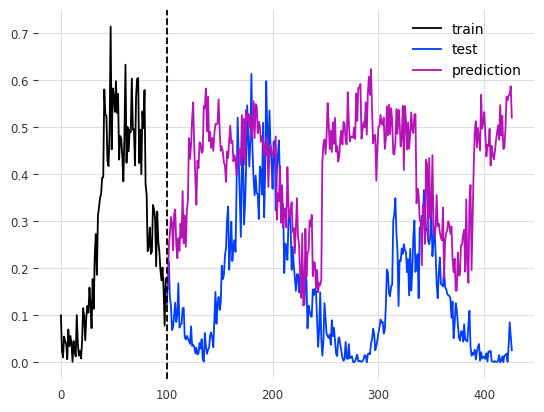

10 steps horizon - rmse = 0.1579
50 steps horizon - rmse = 0.3517
100 steps horizon - rmse = 0.2732
200 steps horizon - rmse = 0.3142
300 steps horizon - rmse = 0.2995
327 steps horizon - rmse = 0.3184


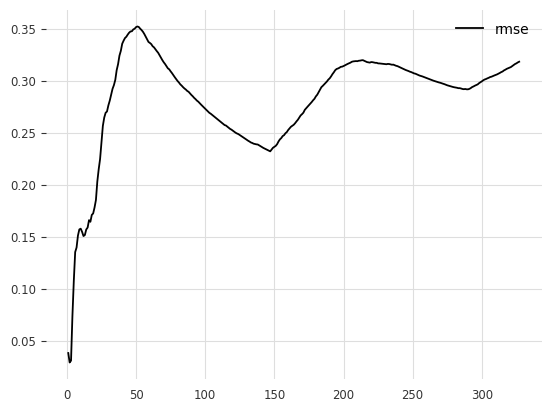


******************************



/home/glegeza/Programming/semestr1/time-series-forecasting/utils/predictors.py:373: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  X_extended["weekofyear"] = pd.Int64Index(X.index.isocalendar().week)


DATASET.ELECTRICITY


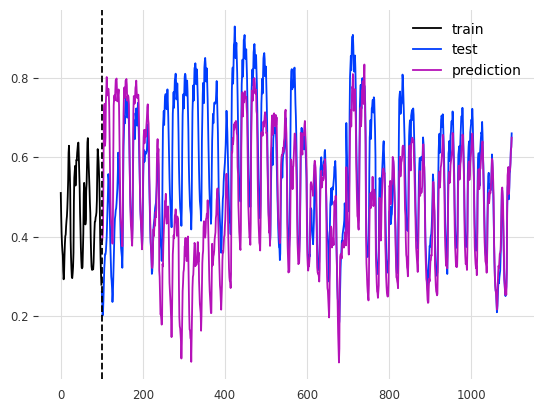

10 steps horizon - rmse = 0.2965
50 steps horizon - rmse = 0.2515
100 steps horizon - rmse = 0.1816
200 steps horizon - rmse = 0.2089
300 steps horizon - rmse = 0.2556
1000 steps horizon - rmse = 0.1574
3524 steps horizon - rmse = 0.1196


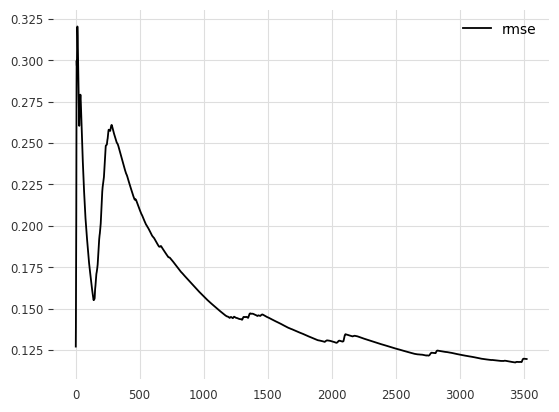


******************************

DATASET.MACKEY_GLASS


/home/glegeza/Programming/semestr1/time-series-forecasting/utils/predictors.py:373: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  X_extended["weekofyear"] = pd.Int64Index(X.index.isocalendar().week)


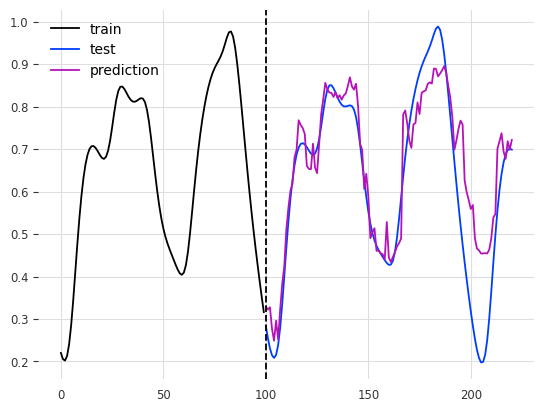

10 steps horizon - rmse = 0.0573
50 steps horizon - rmse = 0.0413
100 steps horizon - rmse = 0.0763
121 steps horizon - rmse = 0.1008


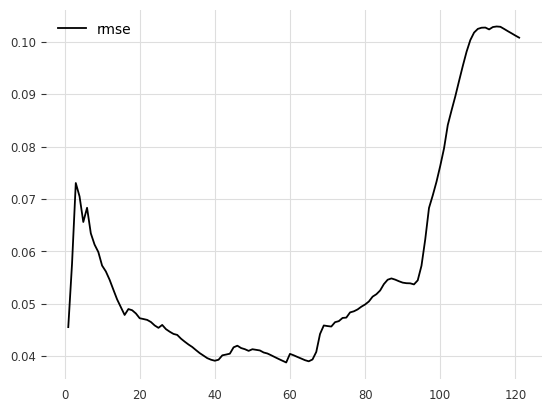


******************************

DATASET.TEMPERATURE


/home/glegeza/Programming/semestr1/time-series-forecasting/utils/predictors.py:373: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  X_extended["weekofyear"] = pd.Int64Index(X.index.isocalendar().week)


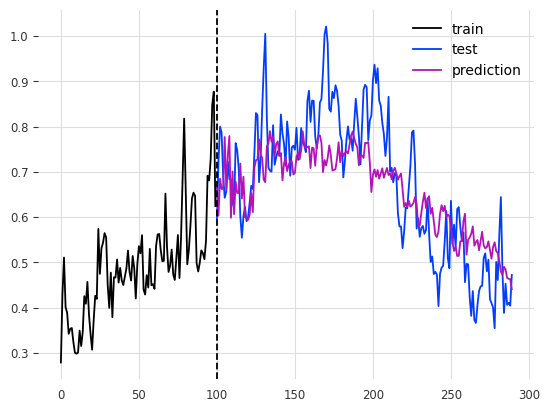

10 steps horizon - rmse = 0.091
50 steps horizon - rmse = 0.0909
100 steps horizon - rmse = 0.1023
190 steps horizon - rmse = 0.1032


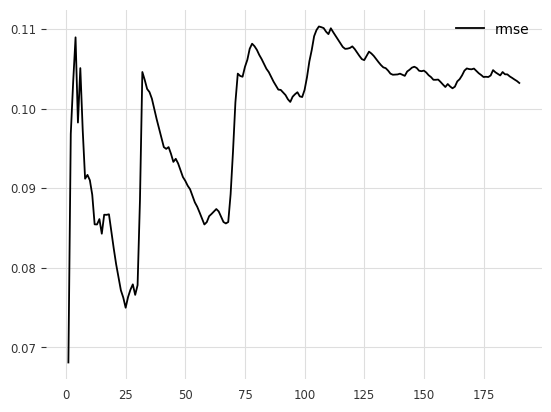


******************************



In [20]:
forecasts = {}
for i, dataset in enumerate(datasets):
    y_val = dataset.y_val
    df_val = pd.DataFrame({"ds": dataset.y_val_df.ds})
    model = models[dataset.name]
    y_pred = model.forecast(df_val)

    print(dataset.name)
    
    plot_predictions(dataset.y_train[-MAX_PLOT_TRAIN: ].flatten(), y_val[:MAX_PLOT_HORIZON].flatten(), y_pred[:MAX_PLOT_HORIZON].flatten())
    plt.show()

    rmse = calculate_rmse(y_val.flatten(), y_pred.flatten())
    plt.show()
    print()
    print("*" * 30)
    print()

    EVALUATION_RESULTS[model_name][dataset.name]["prediction"] = y_pred
    EVALUATION_RESULTS[model_name][dataset.name]["rmse"] = rmse

# Forecasting with ESN

## Train model

In [21]:
model_name = "esn"
EVALUATION_RESULTS[model_name] = {}

models = {}
datasets = [sunspots, electricity, mackey_glass, temperature]
for dataset in datasets:
    print(dataset.name)
    X_train, y_train = dataset.X_train, dataset.y_train
    print(X_train.shape, y_train.shape)
    model = predictors.ESNPredictor(input_size=1, hidden_size=1000, output_size=1, num_layers=4)
    model.fit(X_train, y_train)
    models[dataset.name] = model

    EVALUATION_RESULTS[model_name][dataset.name] = {}
    EVALUATION_RESULTS[model_name][dataset.name]["model"] = model

DATASET.SUNSPOTS
(2937, 1) (2937, 1)
DATASET.ELECTRICITY
(31706, 1) (31706, 1)
DATASET.MACKEY_GLASS
(1079, 1) (1079, 1)
DATASET.TEMPERATURE
(1696, 1) (1696, 1)


## Evaluate model

DATASET.SUNSPOTS


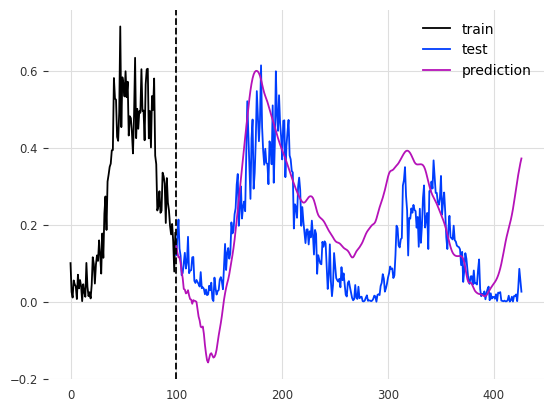

10 steps horizon - rmse = 0.0557
50 steps horizon - rmse = 0.1121
100 steps horizon - rmse = 0.1209
200 steps horizon - rmse = 0.1248
300 steps horizon - rmse = 0.1224
327 steps horizon - rmse = 0.1301


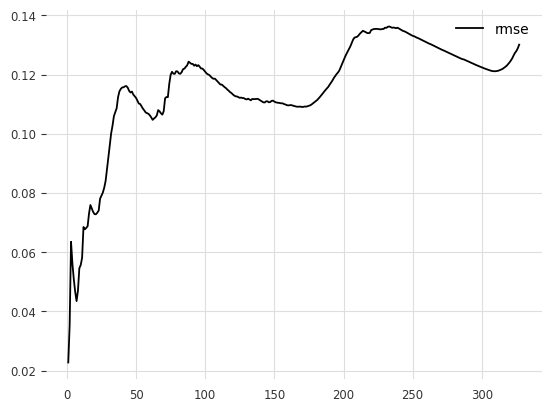


******************************

DATASET.ELECTRICITY


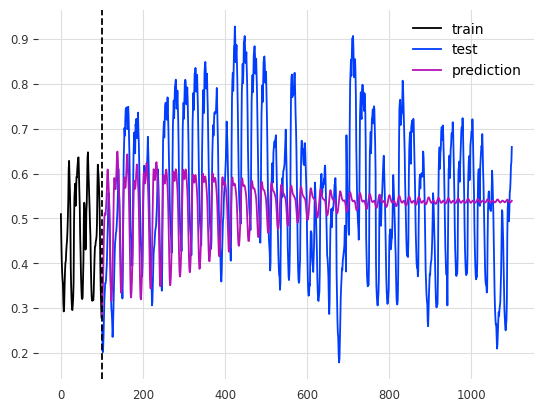

10 steps horizon - rmse = 0.1489
50 steps horizon - rmse = 0.1183
100 steps horizon - rmse = 0.1157
200 steps horizon - rmse = 0.1195
300 steps horizon - rmse = 0.1363
1000 steps horizon - rmse = 0.1536
3524 steps horizon - rmse = 0.158


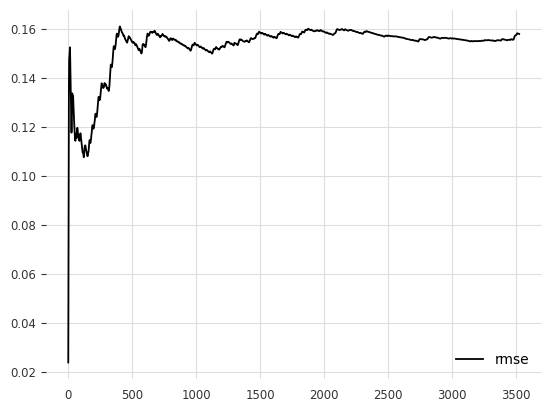


******************************

DATASET.MACKEY_GLASS


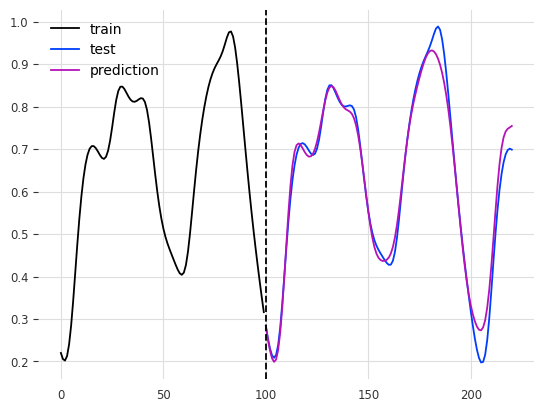

10 steps horizon - rmse = 0.0082
50 steps horizon - rmse = 0.0132
100 steps horizon - rmse = 0.0223
121 steps horizon - rmse = 0.0319


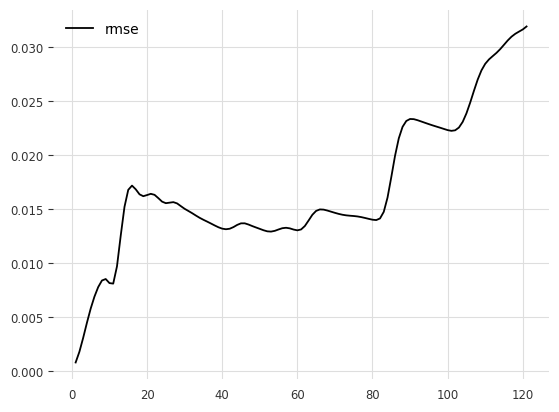


******************************

DATASET.TEMPERATURE


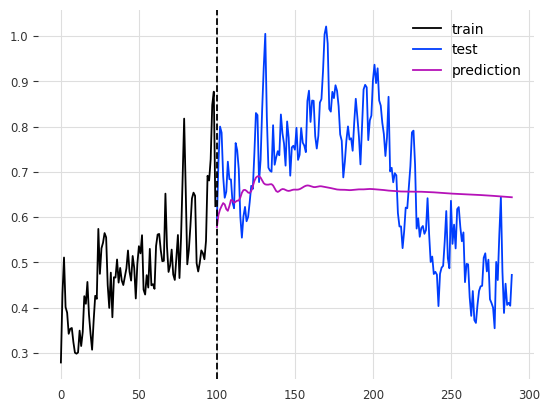

10 steps horizon - rmse = 0.0982
50 steps horizon - rmse = 0.1075
100 steps horizon - rmse = 0.1431
190 steps horizon - rmse = 0.1515


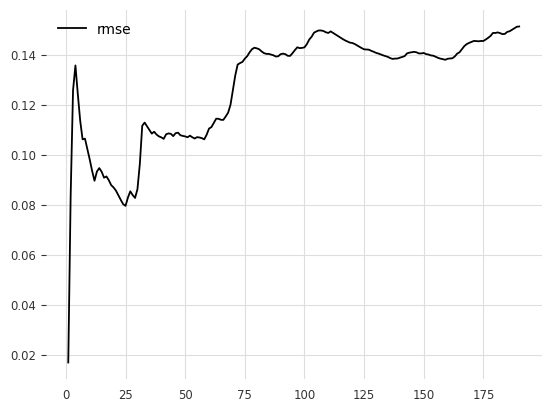


******************************



In [22]:
forecasts = {}
for dataset in datasets:
    y_val = dataset.y_val
    model = models[dataset.name]
    y_pred = model.forecast(y_val.shape[0])
    print(dataset.name)
    
    plot_predictions(dataset.y_train[-MAX_PLOT_TRAIN: ].flatten(), y_val[:MAX_PLOT_HORIZON].flatten(), y_pred[:MAX_PLOT_HORIZON].flatten())
    plt.show()

    rmse = calculate_rmse(y_val.flatten(), y_pred.flatten())
    plt.show()
    print()
    print("*" * 30)
    print()

    EVALUATION_RESULTS[model_name][dataset.name]["prediction"] = y_pred
    EVALUATION_RESULTS[model_name][dataset.name]["rmse"] = rmse

# Evaluation

In [37]:
from darts.metrics import metrics
from darts.timeseries import TimeSeries
from IPython.display import display
from math import ceil

model_names = EVALUATION_RESULTS.keys()
EVALUATION_DF = pd.DataFrame(columns=["dataset name", "model name"])

darts_metrics = {
    "rmse": metrics.rmse,
    "dtw": metrics.dtw_metric,
    "mae": metrics.mae,
    "ope": metrics.ope,
}

In [38]:
def make_evaluation(dataset):
    eval_df = pd.DataFrame()
    dataset_name = dataset.name

    y_train = dataset.y_train[-MAX_PLOT_TRAIN: ].flatten()
    y_test = dataset.y_val[:MAX_PLOT_HORIZON].flatten()
    xrange_train = np.arange(y_train.shape[0])
    xrange_test = np.arange(y_train.shape[0], y_train.shape[0] + y_test.shape[0])

    fig, axs = plt.subplots(ceil(len(model_names) / 2), 2, figsize=(15, 15))
    for num, model_name in enumerate(model_names):
        i = num // 2
        j = num % 2

        sns.lineplot(y=y_train, x=xrange_train, label="train", ax=axs[i, j])
        sns.lineplot(y=y_test, x=xrange_test, label="test", ax=axs[i, j])
        y_pred = EVALUATION_RESULTS[model_name][dataset_name]["prediction"].flatten()
        sns.lineplot(y=y_pred[:MAX_PLOT_HORIZON], x=xrange_test, label=model_name, ax=axs[i, j], color="green")
        axs[i, j].axvline(x=y_train.shape[0], linestyle="--", color="black")
        axs[i, j].set_title(f"model: {model_name}")
    plt.show()


    plt.figure(figsize=(7, 7))
    plt.title("RMSE")
    for model_name in model_names:
        rmse = EVALUATION_RESULTS[model_name][dataset_name]["rmse"][:MAX_PLOT_HORIZON]
        predicted_days = np.arange(1, rmse.shape[0]+1)
        sns.lineplot(y=rmse, x=predicted_days, label=model_name)
    plt.show()

    plt.figure(figsize=(7, 7))
    plt.title("RMSE - 50 steps")
    for model_name in model_names:
        rmse = EVALUATION_RESULTS[model_name][dataset_name]["rmse"][:50]
        predicted_days = np.arange(1, rmse.shape[0]+1)
        sns.lineplot(y=rmse, x=predicted_days, label=model_name)
    plt.show()

    HORIZONS = [1, 10, 20, 50, 100, 250]

    for model_name in model_names:
        rmse = EVALUATION_RESULTS[model_name][dataset_name]["rmse"]
        row = {"dataset name": [dataset_name.value], "model name": [model_name]}
        for h in HORIZONS:
            if h > rmse.shape[0]:
                row[f"rmse - {h}"] = [None]
                continue
            row[f"rmse - {h}"] = [rmse[h - 1]]

        y_pred = EVALUATION_RESULTS[model_name][dataset_name]["prediction"].flatten()
        pred = TimeSeries.from_values(y_pred)
        test = TimeSeries.from_values(y_test)

        for label, metric in darts_metrics.items():
            row[label] = [metric(test, pred)]

        eval_df = pd.concat([eval_df, pd.DataFrame(row)], ignore_index=True)

    darts_metrics_df = eval_df.loc[eval_df["dataset name"] == dataset_name][["model name"] + list(darts_metrics.keys())].copy()
    darts_metrics_df = darts_metrics_df.set_index("model name")
    darts_metrics_df = darts_metrics_df / darts_metrics_df.max(axis=0)
    darts_metrics_df = darts_metrics_df.stack().to_frame().reset_index()
    darts_metrics_df.columns = ["model", "metric", "normalized value"]

    plt.figure(figsize=(7, 7))
    sns.lineplot(data=darts_metrics_df, x="metric", y="normalized value", hue="model", marker="o")
    plt.show()

    display(eval_df.loc[eval_df["dataset name"] == dataset_name])

    return eval_df

## Mackey Glass

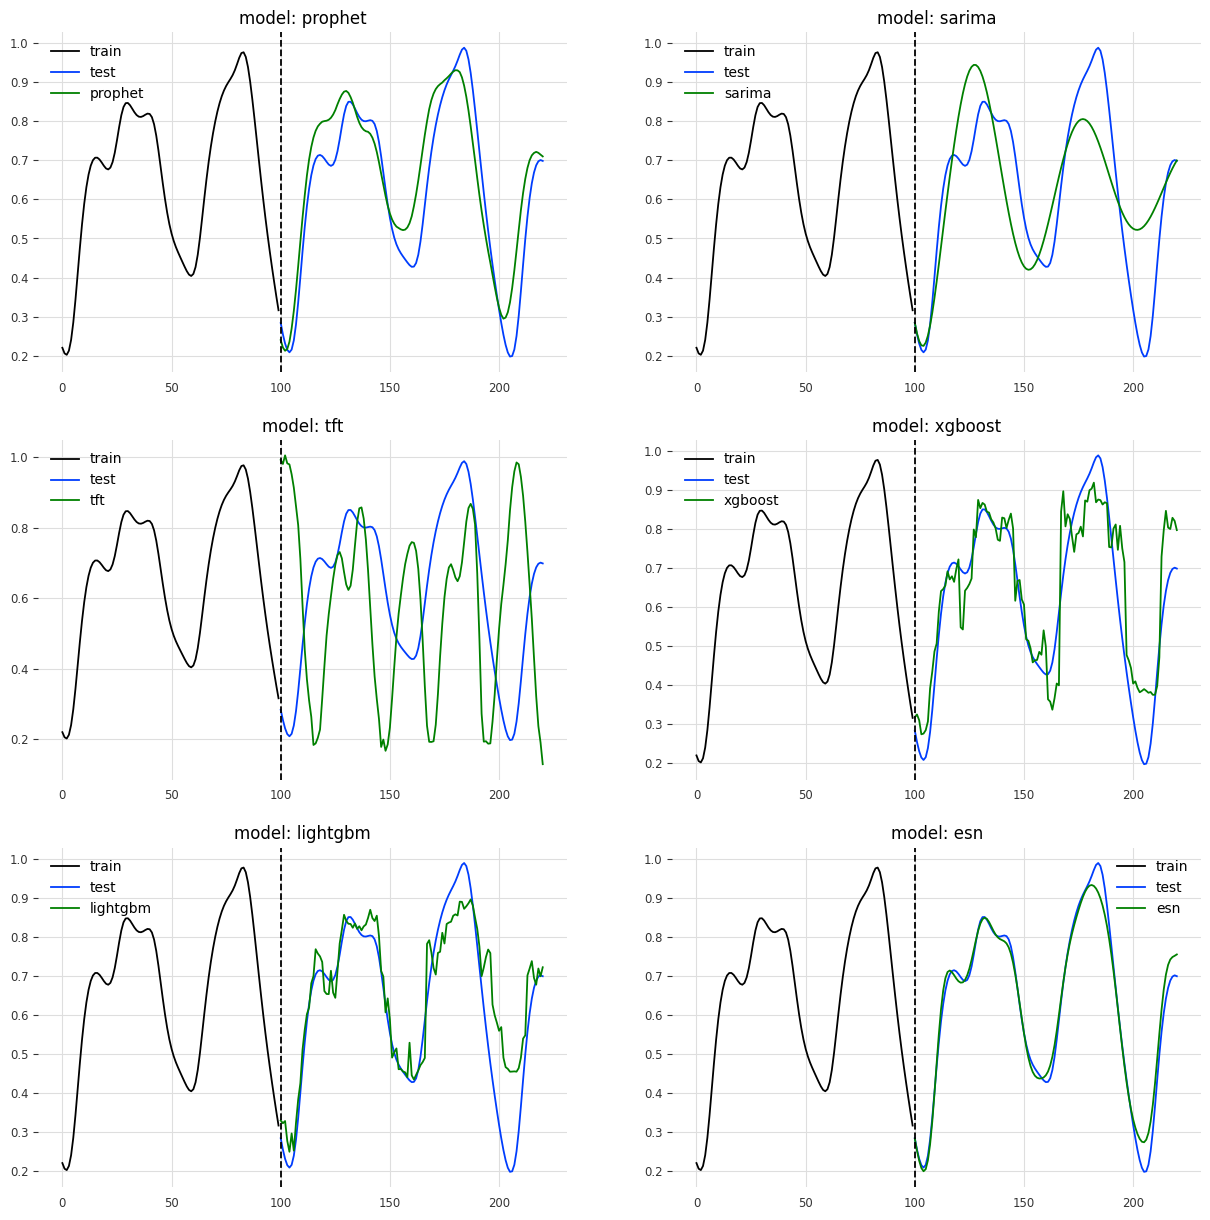

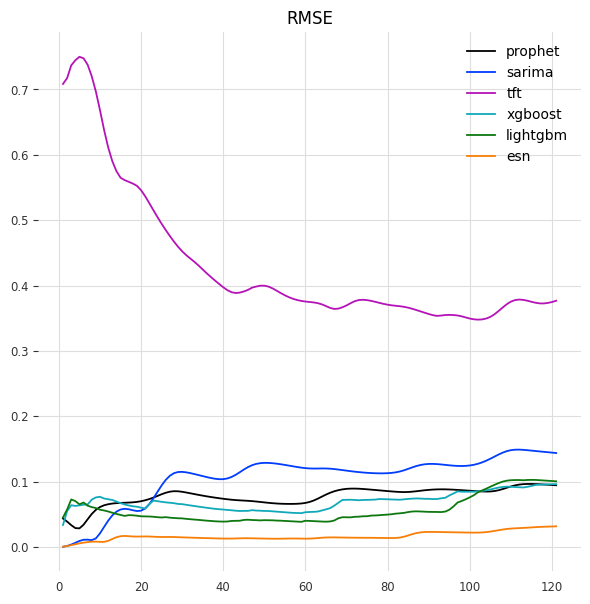

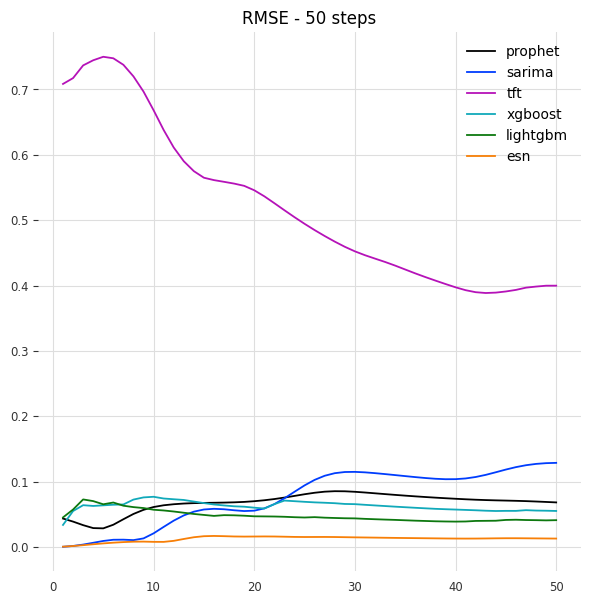

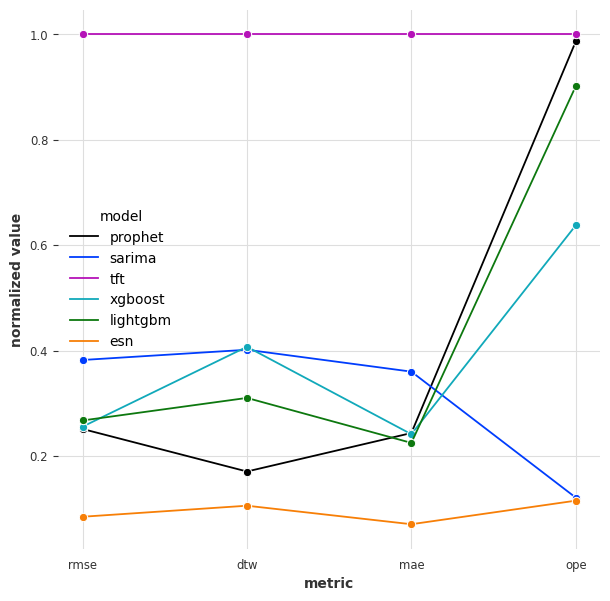

dataset name model name  rmse - 1  rmse - 10  rmse - 20  rmse - 50  \
0  mackey_glass    prophet  0.043812   0.061428   0.070326   0.068495   
1  mackey_glass     sarima  0.000632   0.021161   0.055848   0.128969   
2  mackey_glass        tft  0.708485   0.668262   0.545862   0.399955   
3  mackey_glass    xgboost  0.034045   0.077102   0.060430   0.055410   
4  mackey_glass   lightgbm  0.045543   0.057285   0.047238   0.041321   
5  mackey_glass        esn  0.000812   0.008165   0.016318   0.013190   

   rmse - 100 rmse - 250      rmse       dtw       mae       ope  
0    0.086336       None  0.094699  0.019092  0.076406  6.831822  
1    0.124982       None  0.144024  0.044945  0.112940  0.838516  
2    0.349650       None  0.376967  0.111952  0.313752  6.927282  
3    0.084846       None  0.096346  0.045578  0.075709  4.415606  
4    0.076327       None  0.100777  0.034718  0.070534  6.243940  
5    0.022336       None  0.031935  0.011828  0.022133  0.798186

In [39]:
res_df = make_evaluation(mackey_glass)
EVALUATION_DF = pd.concat([EVALUATION_DF, res_df], ignore_index=True)

# Sunspots

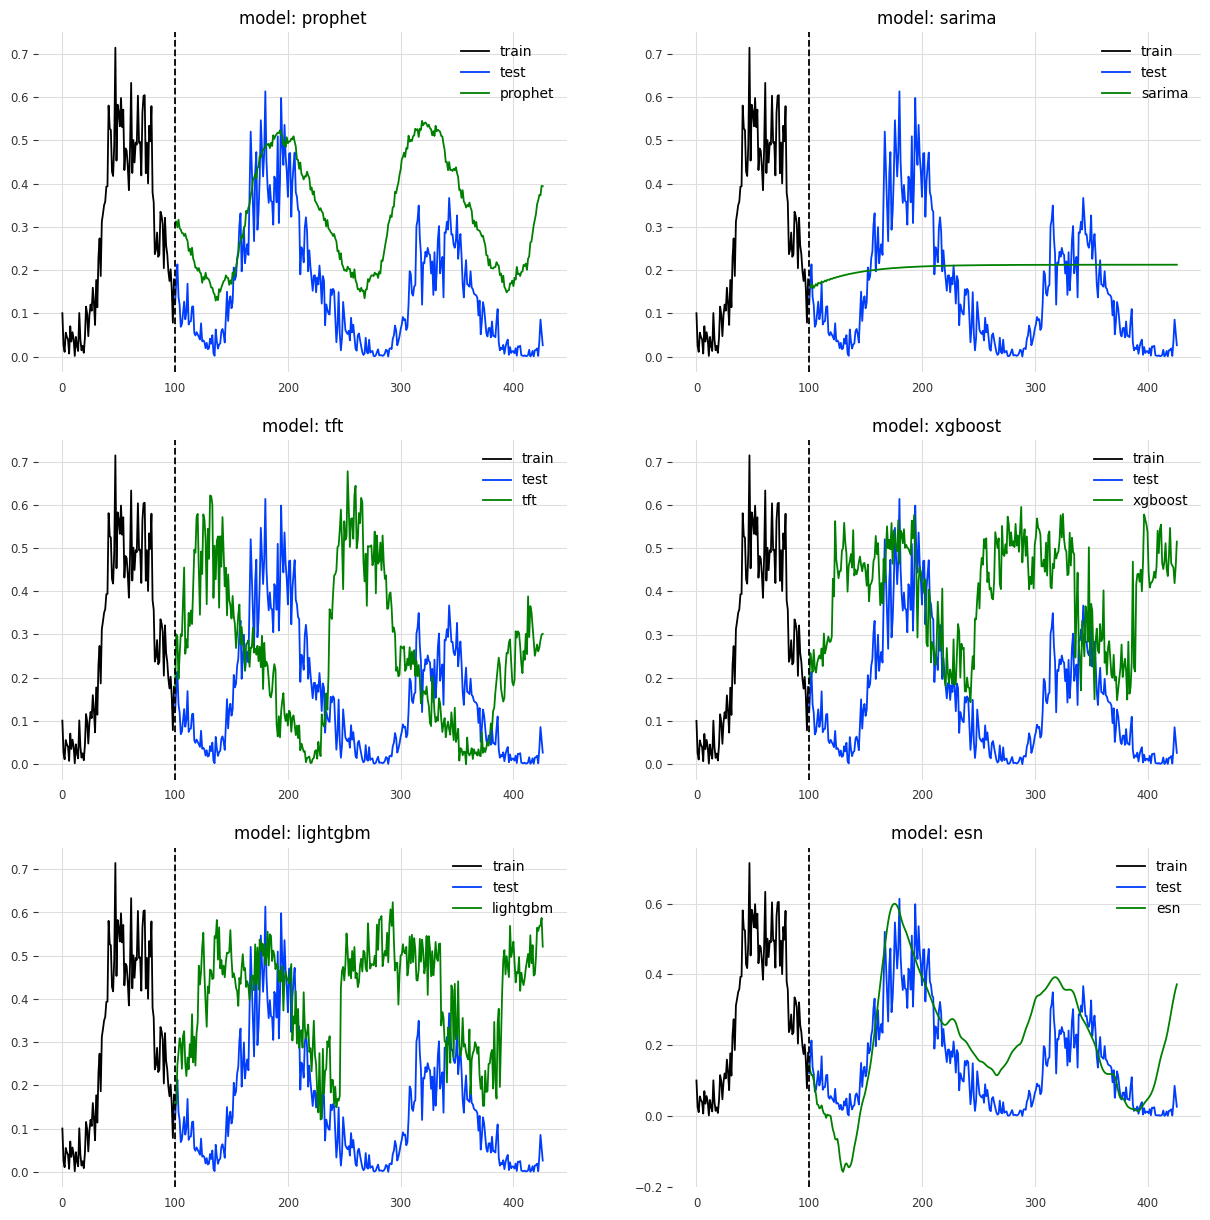

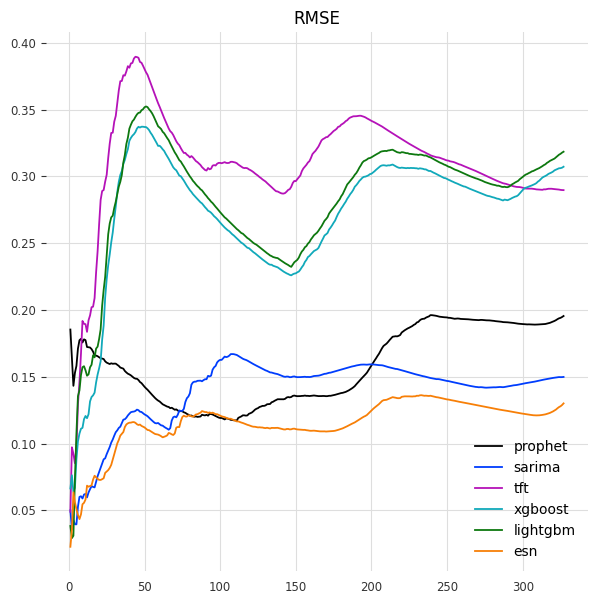

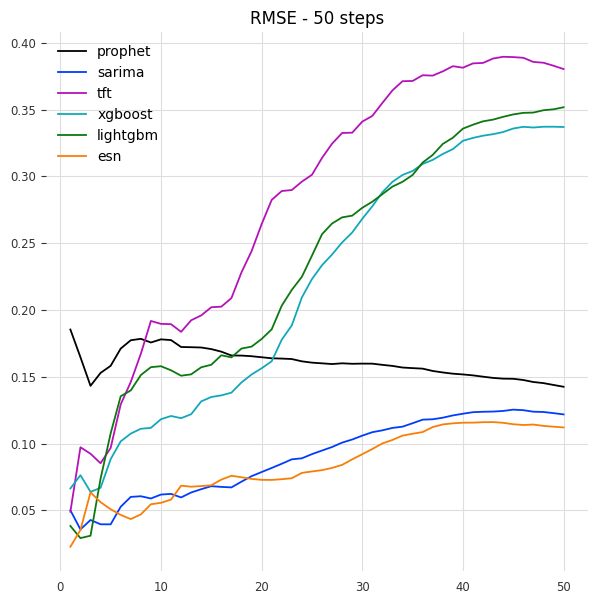

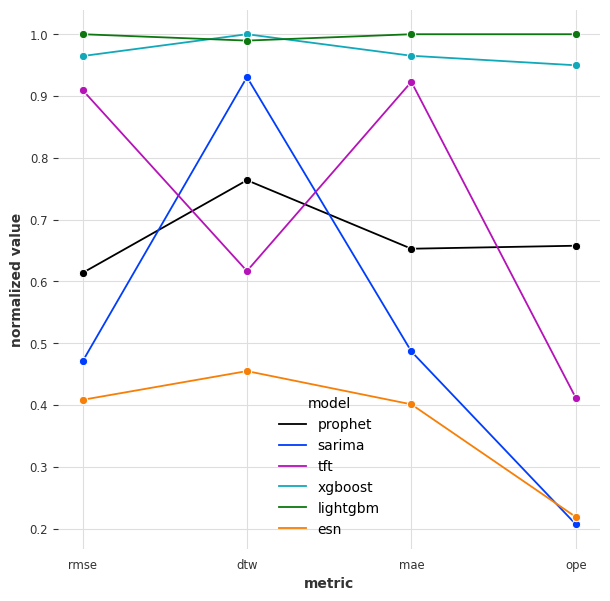

dataset name model name  rmse - 1  rmse - 10  rmse - 20  rmse - 50  \
0     sunspots    prophet  0.185351   0.178012   0.164624   0.142535   
1     sunspots     sarima  0.050093   0.061861   0.078714   0.121844   
2     sunspots        tft  0.049010   0.189603   0.264163   0.380302   
3     sunspots    xgboost  0.066413   0.118244   0.156345   0.336914   
4     sunspots   lightgbm  0.038350   0.157907   0.178271   0.351697   
5     sunspots        esn  0.022782   0.055679   0.072860   0.112106   

   rmse - 100  rmse - 250      rmse       dtw       mae         ope  
0    0.119148    0.194410  0.195480  0.064853  0.173841  110.723146  
1    0.162654    0.146871  0.149876  0.079017  0.129588   34.887256  
2    0.310074    0.311896  0.289688  0.052377  0.245721   69.332926  
3    0.265367    0.298002  0.307187  0.084906  0.256955  159.865445  
4    0.273170    0.307816  0.318431  0.084030  0.266231  168.319770  
5    0.120939    0.133048  0.130079  0.038634  0.106814   36.874594

In [40]:
res_df = make_evaluation(sunspots)
EVALUATION_DF = pd.concat([EVALUATION_DF, res_df], ignore_index=True)

# Electricity

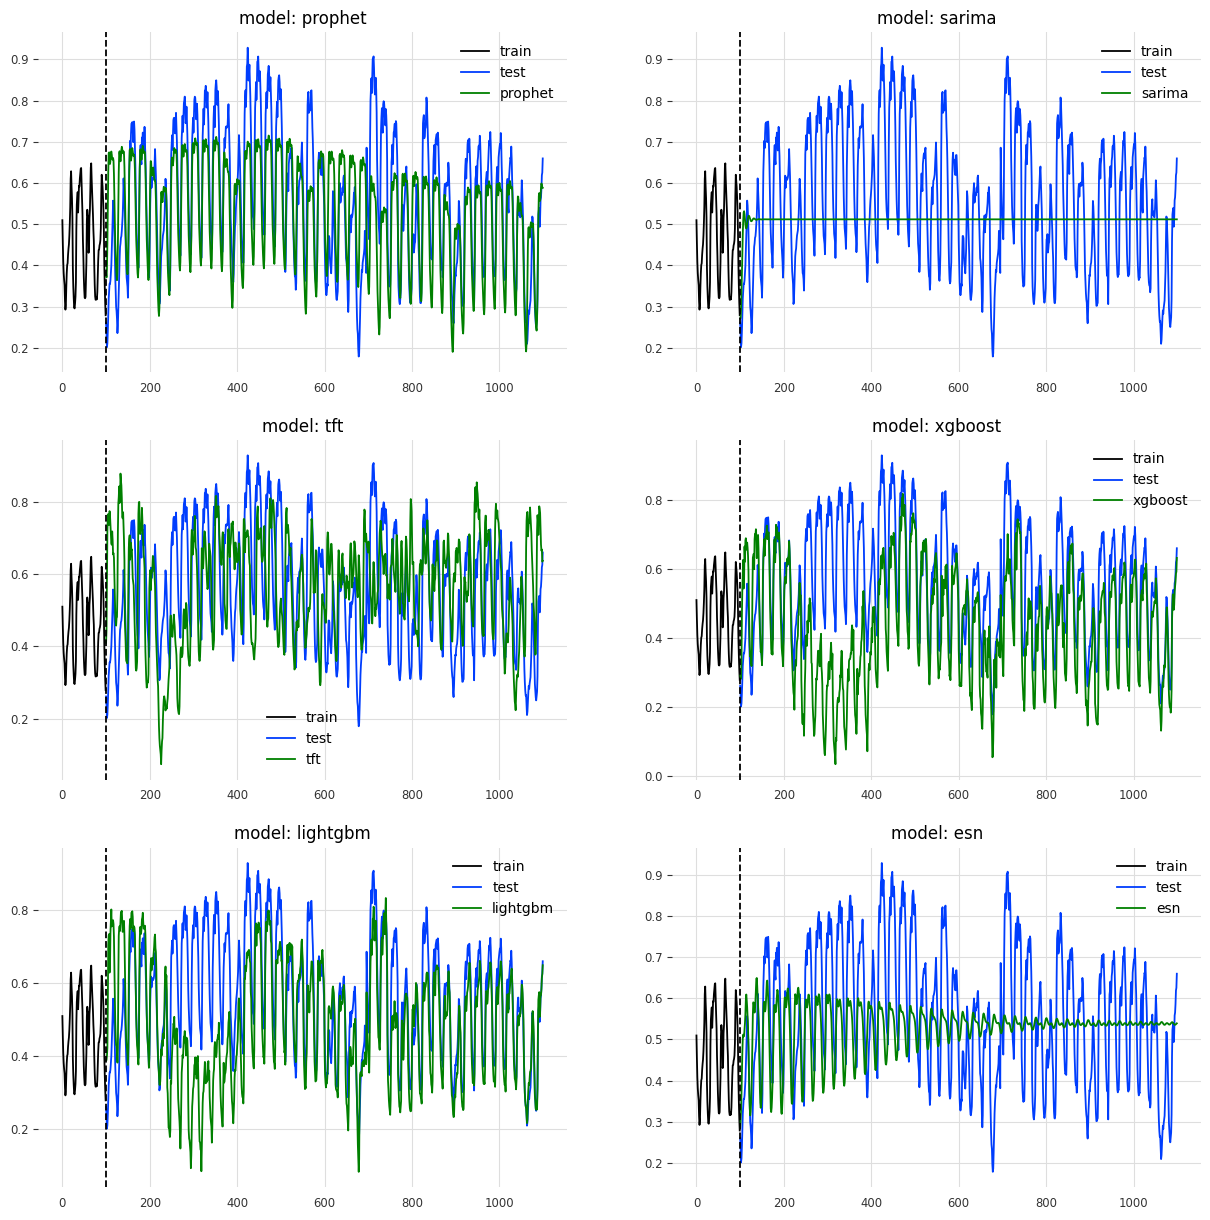

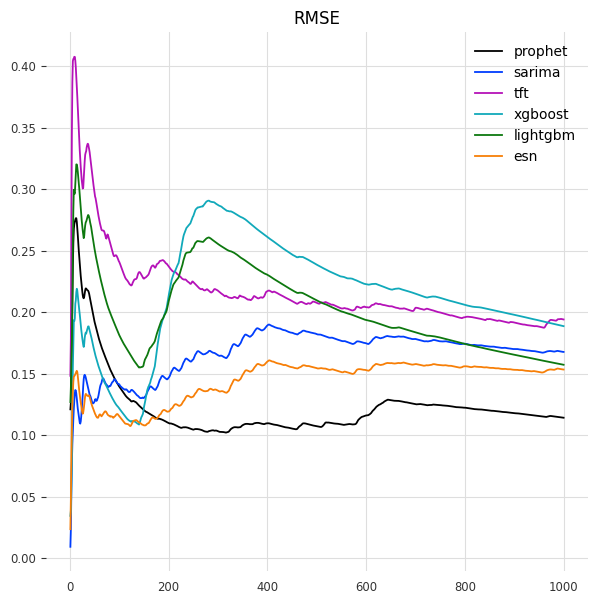

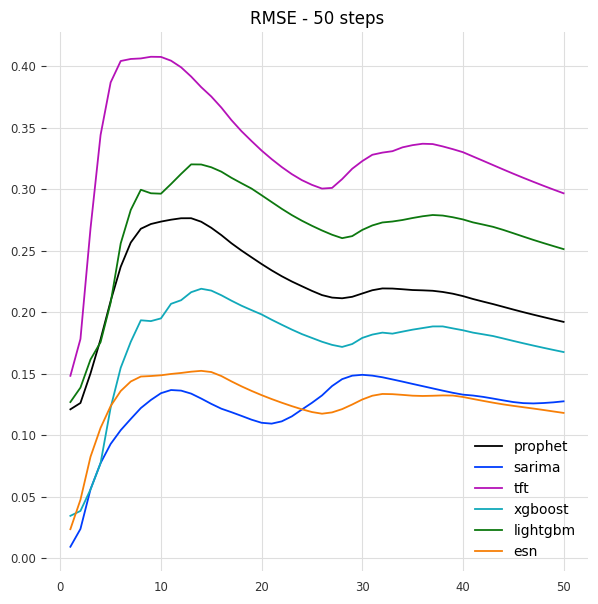

Exact evaluation will result in poor performance on large datasets. Consider enabling multi-grid or using a window.
Exact evaluation will result in poor performance on large datasets. Consider enabling multi-grid or using a window.
Exact evaluation will result in poor performance on large datasets. Consider enabling multi-grid or using a window.
Exact evaluation will result in poor performance on large datasets. Consider enabling multi-grid or using a window.
Exact evaluation will result in poor performance on large datasets. Consider enabling multi-grid or using a window.


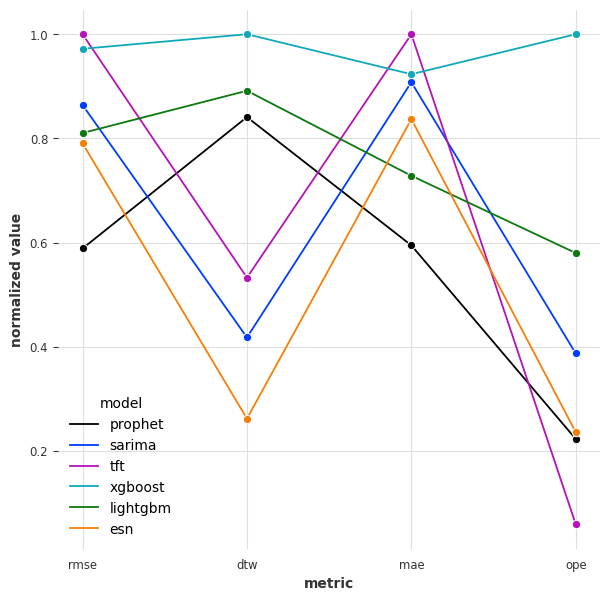

dataset name model name  rmse - 1  rmse - 10  rmse - 20  rmse - 50  \
0  electricity    prophet  0.121207   0.273848   0.239340   0.192315   
1  electricity     sarima  0.009447   0.134328   0.110261   0.127719   
2  electricity        tft  0.148439   0.407742   0.331593   0.296868   
3  electricity    xgboost  0.034597   0.195151   0.198350   0.167786   
4  electricity   lightgbm  0.127113   0.296542   0.295259   0.251474   
5  electricity        esn  0.023749   0.148885   0.132746   0.118285   

   rmse - 100  rmse - 250      rmse       dtw       mae        ope  
0    0.139738    0.104660  0.114383  0.069696  0.091642   5.000596  
1    0.141524    0.161821  0.167880  0.034646  0.139889   8.678428  
2    0.241085    0.224682  0.194275  0.044158  0.154080   1.335707  
3    0.121923    0.278381  0.188839  0.082876  0.142253  22.406877  
4    0.181559    0.252547  0.157449  0.073887  0.112226  12.998483  
5    0.115701    0.131542  0.153575  0.021734  0.128986   5.293033

In [41]:
res_df = make_evaluation(electricity)
EVALUATION_DF = pd.concat([EVALUATION_DF, res_df], ignore_index=True)

# Temperature

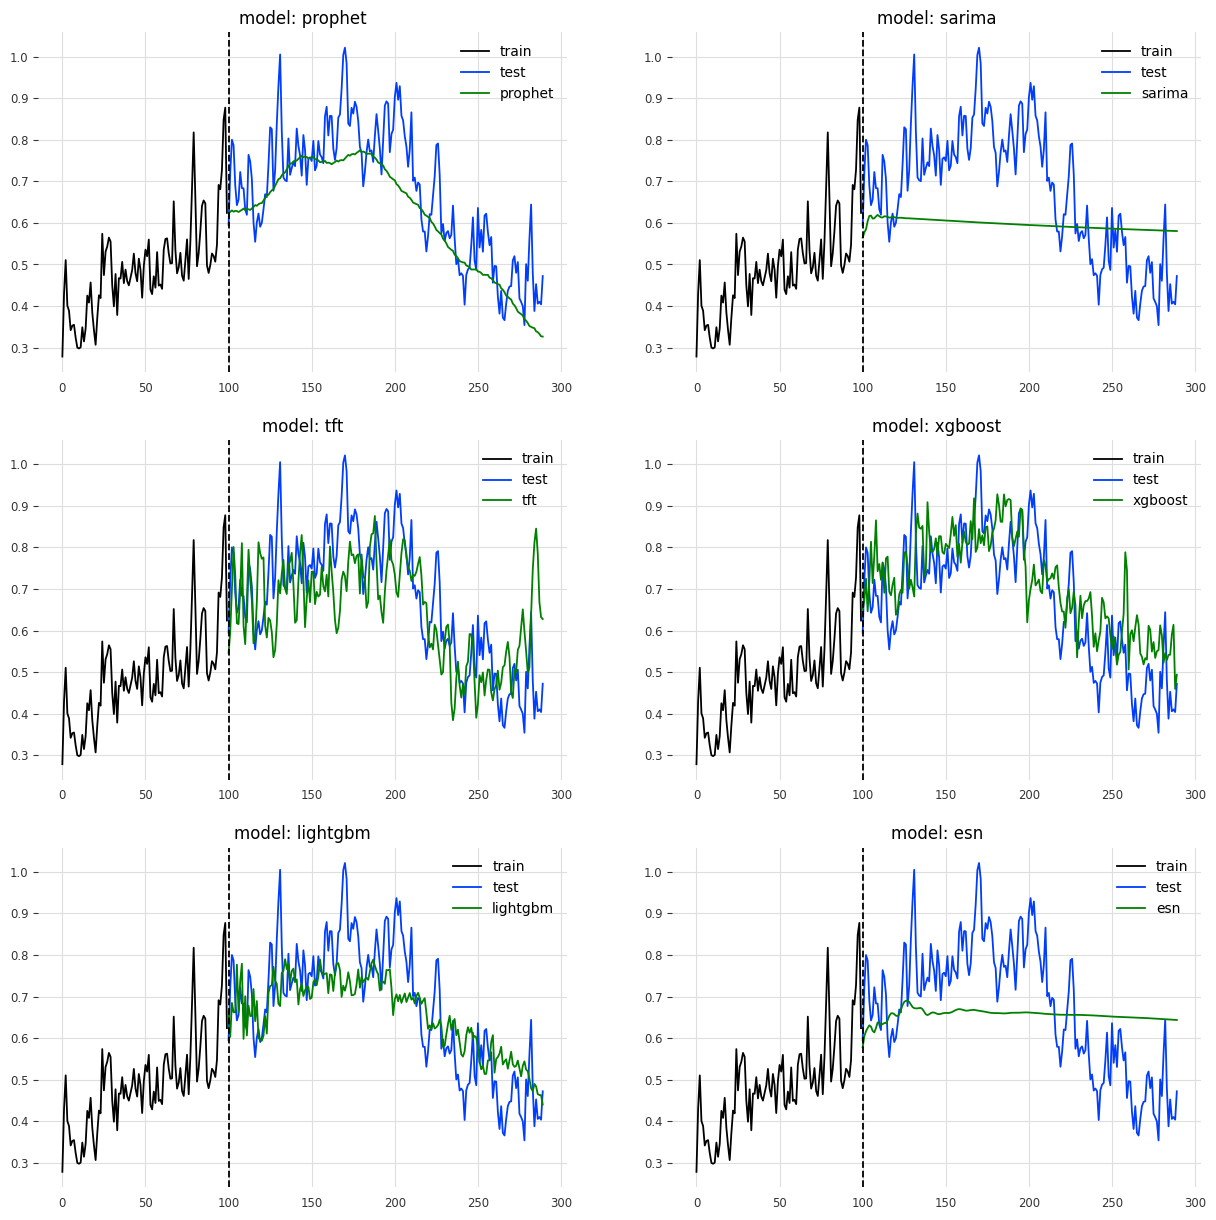

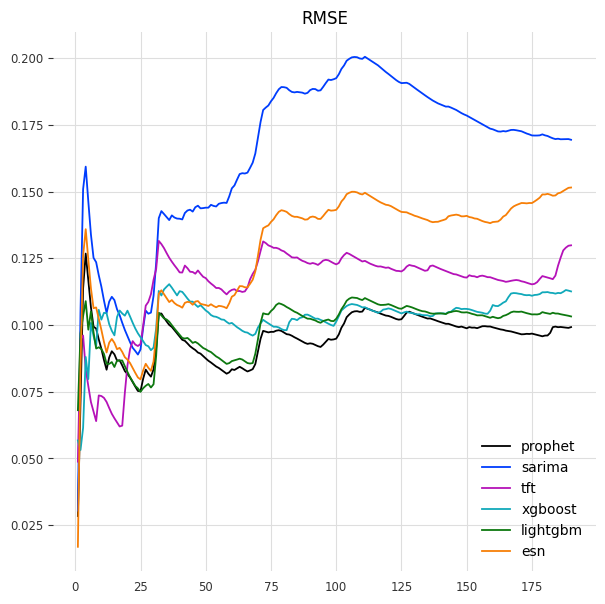

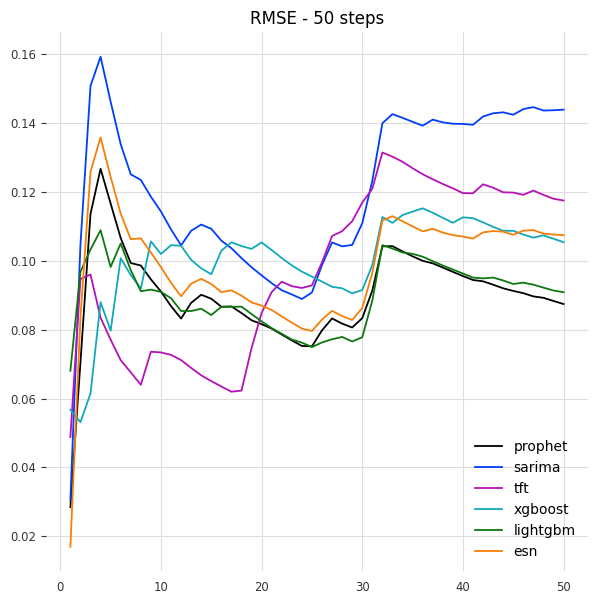

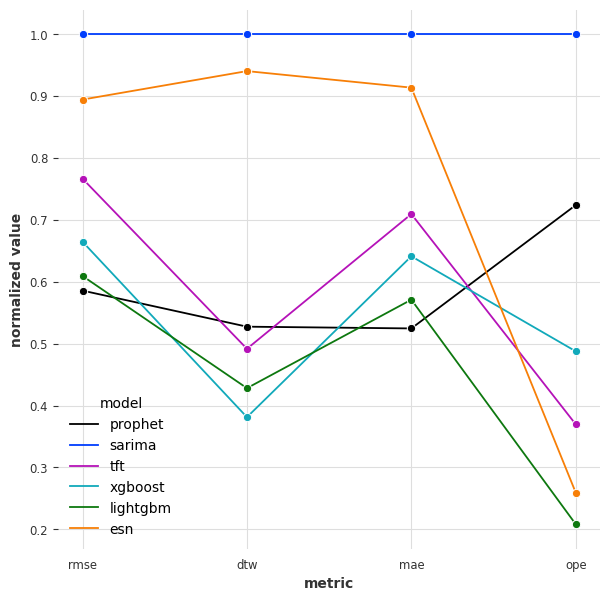

dataset name model name  rmse - 1  rmse - 10  rmse - 20  rmse - 50  \
0  temperature    prophet  0.028446   0.091093   0.081625   0.087469   
1  temperature     sarima  0.030483   0.114358   0.095799   0.143949   
2  temperature        tft  0.048812   0.073402   0.084873   0.117548   
3  temperature    xgboost  0.056749   0.102009   0.105369   0.105440   
4  temperature   lightgbm  0.068091   0.090985   0.082429   0.090912   
5  temperature        esn  0.016927   0.098193   0.087017   0.107466   

   rmse - 100 rmse - 250      rmse       dtw       mae        ope  
0    0.094878       None  0.099216  0.042517  0.074722   8.575235  
1    0.192450       None  0.169374  0.080602  0.142422  11.845481  
2    0.122704       None  0.129840  0.039636  0.101042   4.379597  
3    0.101266       None  0.112583  0.030734  0.091326   5.777015  
4    0.102338       None  0.103206  0.034509  0.081343   2.467824  
5    0.143126       None  0.151492  0.075799  0.130131   3.072369

In [42]:
res_df = make_evaluation(temperature)
EVALUATION_DF = pd.concat([EVALUATION_DF, res_df], ignore_index=True)

In [44]:
EVALUATION_DF

dataset name model name  rmse - 1  rmse - 10  rmse - 20  rmse - 50  \
0   mackey_glass    prophet  0.043812   0.061428   0.070326   0.068495   
1   mackey_glass     sarima  0.000632   0.021161   0.055848   0.128969   
2   mackey_glass        tft  0.708485   0.668262   0.545862   0.399955   
3   mackey_glass    xgboost  0.034045   0.077102   0.060430   0.055410   
4   mackey_glass   lightgbm  0.045543   0.057285   0.047238   0.041321   
5   mackey_glass        esn  0.000812   0.008165   0.016318   0.013190   
6       sunspots    prophet  0.185351   0.178012   0.164624   0.142535   
7       sunspots     sarima  0.050093   0.061861   0.078714   0.121844   
8       sunspots        tft  0.049010   0.189603   0.264163   0.380302   
9       sunspots    xgboost  0.066413   0.118244   0.156345   0.336914   
10      sunspots   lightgbm  0.038350   0.157907   0.178271   0.351697   
11      sunspots        esn  0.022782   0.055679   0.072860   0.112106   
12   electricity    prophet  0.121207   0.273848   0.239340   0.192315   
13   electricity     sarima  0.009447   0.134328   0.110261   0.127719   
14   electricity        tft  0.148439   0.407742   0.331593   0.296868   
15   electricity    xgboost  0.034597   0.195151   0.198350   0.167786   
16   electricity   lightgbm  0.127113   0.296542   0.295259   0.251474   
17   electricity        esn  0.023749   0.148885   0.132746   0.118285   
18   temperature    prophet  0.028446   0.091093   0.081625   0.087469   
19   temperature     sarima  0.030483   0.114358   0.095799   0.143949   
20   temperature        tft  0.048812   0.073402   0.084873   0.117548   
21   temperature    xgboost  0.056749   0.102009   0.105369   0.105440   
22   temperature   lightgbm  0.068091   0.090985   0.082429   0.090912   
23   temperature        esn  0.016927   0.098193   0.087017   0.107466   

    rmse - 100 rmse - 250      rmse       dtw       mae         ope  
0     0.086336        NaN  0.094699  0.019092  0.076406    6.831822  
1     0.124982        NaN  0.144024  0.044945  0.112940    0.838516  
2     0.349650        NaN  0.376967  0.111952  0.313752    6.927282  
3     0.084846        NaN  0.096346  0.045578  0.075709    4.415606  
4     0.076327        NaN  0.100777  0.034718  0.070534    6.243940  
5     0.022336        NaN  0.031935  0.011828  0.022133    0.798186  
6     0.119148    0.19441  0.195480  0.064853  0.173841  110.723146  
7     0.162654   0.146871  0.149876  0.079017  0.129588   34.887256  
8     0.310074   0.311896  0.289688  0.052377  0.245721   69.332926  
9     0.265367   0.298002  0.307187  0.084906  0.256955  159.865445  
10    0.273170   0.307816  0.318431  0.084030  0.266231  168.319770  
11    0.120939   0.133048  0.130079  0.038634  0.106814   36.874594  
12    0.139738    0.10466  0.114383  0.069696  0.091642    5.000596  
13    0.141524   0.161821  0.167880  0.034646  0.139889    8.678428  
14    0.241085   0.224682  0.194275  0.044158  0.154080    1.335707  
15    0.121923   0.278381  0.188839  0.082876  0.142253   22.406877  
16    0.181559   0.252547  0.157449  0.073887  0.112226   12.998483  
17    0.115701   0.131542  0.153575  0.021734  0.128986    5.293033  
18    0.094878       None  0.099216  0.042517  0.074722    8.575235  
19    0.192450       None  0.169374  0.080602  0.142422   11.845481  
20    0.122704       None  0.129840  0.039636  0.101042    4.379597  
21    0.101266       None  0.112583  0.030734  0.091326    5.777015  
22    0.102338       None  0.103206  0.034509  0.081343    2.467824  
23    0.143126       None  0.151492  0.075799  0.130131    3.072369